# Capstone project - Brain tumour classification


### Problem statement
Typically to classify a brain tumour, radiologists and neurologists would go manually through MRI scans to locate the tumour and extract information; they would then conclude on the tumour type by performing a biopsy. However going through over a hundred images per patient can be a tedious and time-consuming process.  
Could we accelerate this process by pre-classifying brain tumours based on their MRI scans before a radiologist starts looking at them?  
  
### Dataset
Based on the VASARI brain tumours dataset, we will aim at building a classifier that can differentiate Astrocytomas, Glioblastomas (GBM) and Oligodendrogliomas based on their MRI scans.  
The VASARI dataset contains three different sets of materials:
 - A CSV file containing the diagnosis and survival time of 127 patients
 - MRI scans for these 127 patients
 - A CSV file containing 30 tumour features extracted manually by three neuroradiologists from the MRI scans of 32 patients (glioblastoma, n = 20; oligodendroglioma, n = 7; astrocytoma, n = 5), such as side of tumour epicenter, enhancement quality, enhancing tumour, necrotic tumour, size, etc.
   
### Process
 1. We will first try to build a classifer based on the features manually extracted manually by radiologists. Therefore this notebook will focus mainly on exploring the two CSV files.  
 2. We will then try to extract these features from the MRI scans and make sure that they match those from the CSV file. According to the litterature on brain tumour classfication, this step will require: 
     - Selecting the relevant images to be analysed (out of over 100 per patient)
     - Filtering them to remove the noise inherent to all MR images
     - Segmenting the image to isolate the tumour
     - Extracting relevant features - based on our first model's performance, we might want to add some additional features on top of the VASARI features to improve our model (some papers in particular refer to tumour concavity and texture)
 3. We will then run the same model on the features extracted automatically for the first 32 patients and make sure that we get similar results to the manually extracted features.
 4. Finally we will classify the remaining 95 patients.
   
### Goal and success criteria
Our goal is to build a classifier that performs better than the baseline. We would like to predict probabilities of each tumour type in order to assist radiologists in their diagnosis. We will compare several models (such as Logistic Regression, Naive Bayes and Random Forests) based on their accuracy and confusion matrices and select the most relevant one. We will also try to trim the number of features to improve our model.

### References
 - Scarpace, Lisa, Flanders, Adam E., Jain, Rajan, Mikkelsen, Tom, & Andrews, David W. (2015). Data From REMBRANDT. The Cancer Imaging Archive. http://doi.org/10.7937/K9/TCIA.2015.588OZUZB  
 - Clark K, Vendt B, Smith K, Freymann J, Kirby J, Koppel P, Moore S, Phillips S, Maffitt D, Pringle M, Tarbox L, Prior F. The Cancer Imaging Archive (TCIA): Maintaining and Operating a Public Information Repository, Journal of Digital Imaging, Volume 26, Number 6, December, 2013, pp 1045-1057.
 - PyScience blog, https://pyscience.wordpress.com/

### Contents
1. [Getting the data](#Part1)  
    a. [First CSV file - Tumour features](#Part1a)  
    b. [Second CSV file - Diagnosis](#Part1b)  
    c. [Add patient diagnosis to features dataframe](#Part1c)  
2. [Cleaning the data](#Part2)  
3. [Exploring the data](#Part3)  
4. [Studying feature importance with PCA](#Part4)  
5. [Building and training models on manually extracted features](#Part5)  
    a. [Logistic Regression](#Part5a)  
    b. [KNN](#Part5b)  
    c. [Random Forest](#Part5c)  
    d. [LDA](#Part5d)  
    e. [Naive Bayes](#Part5e)  
    f. [Compare model scores](#Part5f)   
6. [Feature Selection](#Part6)  
    a. [Random Forest Feature Importances](#Part6a)  
    b. [SelectKBest](#Part6b)  
    c. [Recursive Feature Elimination (RFE)](#Part6c)   
    d. [Compare model scores](#Part6d)
7. [Cross-validated results of chosen model: Random forest (n=25) with 5 best features](#Part7)
8. [Extraction of MRI Scans](#Part8)  
    a. [Reshape images](#Part8a)  
    b. [Remove noise](#Part8b)   
    c. [Initial tumour segmentation with thresholding (in 3D)](#Part8c)  
    d. [Selection of slice with largest tumour area](#Part8d)  
    e. [Refined segmentation with Confidence Connected filter on T2 and FLAIR images (in 2D)](#Part8e)   
    f. [Extract tumour VASARI features](#Part8f)  
      i. [Tumour dimensions and Side of tumour epicentre](#Part8f1)
      ii. [T1/FLAIR ratio](#Part8f2)   
      iii. [Enhancement Quality](#Part8f3)  
      iv. [Proportion Enhancing](#Part8f4)  
      v. [Proportion nCET](#Part8f5)  
      vi. [Proportion Necrosis](#Part8f6)   
      vii. [Thickness of enhancing margin](#Part8f7)   
   g. [Store extracted features in a dataframe](#Part8g)
9. [Executive Summary](#Part9)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
%matplotlib inline
pd.set_option("display.max_columns",101)

<a id='Part1'></a>

## 1. Getting the data

<a id='Part1a'></a>

### a. First CSV file - Tumour features

In [2]:
tumour_features = pd.read_excel('VASARI_MRI_features (gmdi - wiki).xls')
tumour_features.head()

,GMDI,ID,radiologist,comments,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30
0,900_00_1961,90,Radiologist #1,well defined insular tumor,"1, 2, 3",1,1,1,1,7,1,1,1,1,1,1,2,3,2,1,2,1,1,2,1,2,1,1,1,1,6,2,12,7
1,900_00_1961,101,Radiologist #2,NaN,"1, 3",1,1,1,1,8,1,1,1,1,1,1,2,2,1,1,4,1,1,2,1,2,1,1,1,1,5,1,11,8
2,900_00_1961,81,Radiologist #3,NaN,3,1,1,1,1,8,1,1,1,1,1,1,2,2,1,1,2,1,1,2,1,2,1,1,1,1,4,1,11,7
3,900_00_5299,176,Radiologist #1,"two components seem to be enhancing and edema,...",2,1,1,3,4,3,4,1,1,2,4,2,2,5,2,1,1,2,1,2,1,2,2,1,1,7,2,3,10,9
4,900_00_5299,161,Radiologist #2,NaN,2,1,1,3,4,3,4,1,2,1,4,2,3,5,2,2,1,2,1,2,1,2,2,2,2,8,2,2,11,8


In [3]:
# Rename columns with meaningful names and drop ID and comments columns

cols = ['Sample','Radiologist','Tumor_Location','Side_of_Tumor_Epicenter','Eloquent_Brain','Enhancement_Quality',
        'Proportion_Enhancing','Proportion_nCET', 'Proportion_Necrosis','Cyst','Multifocal_or_Multicentric',
        'T1_FLAIR_Ratio','Thickness_Enhancing_Margin','Definition_Enhancing_Margin', 'Definition_Non_Enhancing_Margin',
        'Proportion_of_Edema','Edema_Crosses_Midline','Hemorrhage','Diffusion','Pial_Invasion','Ependymal_Invasion',
        'Cortical_Involvement','Deep_WM_Invasion','nCET_Tumor_Crosses_Midline','Enhancing_Tumor_Crosses_Midline',
        'Satellites','Calvarial_Remodeling','Extent_Resection_Enhancing_Tumor','Extent_Resection_nCET',
        'Extent_Resection_Vasogenic_Edema','Lesion_Size_x','Lesion_Size_y']

tumour_features = tumour_features.drop(['ID','comments'], axis=1)
tumour_features.columns = cols
tumour_features.head()

,Sample,Radiologist,Tumor_Location,Side_of_Tumor_Epicenter,Eloquent_Brain,Enhancement_Quality,Proportion_Enhancing,Proportion_nCET,Proportion_Necrosis,Cyst,Multifocal_or_Multicentric,T1_FLAIR_Ratio,Thickness_Enhancing_Margin,Definition_Enhancing_Margin,Definition_Non_Enhancing_Margin,Proportion_of_Edema,Edema_Crosses_Midline,Hemorrhage,Diffusion,Pial_Invasion,Ependymal_Invasion,Cortical_Involvement,Deep_WM_Invasion,nCET_Tumor_Crosses_Midline,Enhancing_Tumor_Crosses_Midline,Satellites,Calvarial_Remodeling,Extent_Resection_Enhancing_Tumor,Extent_Resection_nCET,Extent_Resection_Vasogenic_Edema,Lesion_Size_x,Lesion_Size_y
0,900_00_1961,Radiologist #1,"1, 2, 3",1,1,1,1,7,1,1,1,1,1,1,2,3,2,1,2,1,1,2,1,2,1,1,1,1,6,2,12,7
1,900_00_1961,Radiologist #2,"1, 3",1,1,1,1,8,1,1,1,1,1,1,2,2,1,1,4,1,1,2,1,2,1,1,1,1,5,1,11,8
2,900_00_1961,Radiologist #3,3,1,1,1,1,8,1,1,1,1,1,1,2,2,1,1,2,1,1,2,1,2,1,1,1,1,4,1,11,7
3,900_00_5299,Radiologist #1,2,1,1,3,4,3,4,1,1,2,4,2,2,5,2,1,1,2,1,2,1,2,2,1,1,7,2,3,10,9
4,900_00_5299,Radiologist #2,2,1,1,3,4,3,4,1,2,1,4,2,3,5,2,2,1,2,1,2,1,2,2,2,2,8,2,2,11,8


<a id='Part1b'></a>

### b. Second CSV file - Diagnosis

In [4]:
# Read in CSV and format dataframe

patients_info = pd.read_excel('clinical_2014-01-16.xlsx')
patients_info.drop(patients_info.columns[6:], axis=1, inplace=True)
patients_info.columns = ['Sample','Age','Gender','Survival_months','Disease','Grade']
patients_info.head()

,Sample,Age,Gender,Survival_months,Disease,Grade
0,900_00_1961,--,--,15,ASTROCYTOMA,II
1,900_00_5332,--,--,15,GBM,--
2,900_00_5308,--,--,17,ASTROCYTOMA,III
3,900_00_5316,--,--,17,GBM,--
4,900_00_5317,--,--,17,GBM,--


<a id='Part1c'></a>

### c. Add patient diagnosis to features dataframe

In [5]:
# Merge the two dataframes
tumours = pd.merge(patients_info[['Sample','Disease','Survival_months']], tumour_features, on='Sample', how='inner')

<a id='Part2'></a>

## 2. Cleaning the data

In [6]:
# Assign survival column type to int
tumours['Survival_months'] = tumours['Survival_months'].astype('int')

In [7]:
# Display first index of each disease

print 'Astocytoma first index:', tumours.loc[tumours['Disease']==' ASTROCYTOMA', 'Disease'].index[0]
print 'GBM first index:', tumours.loc[tumours['Disease']==' GBM', 'Disease'].index[0]
print 'Oligodendroglioma first index:', tumours.loc[tumours['Disease']==' OLIGODENDROGLIOMA', 'Disease'].index[0]

Astocytoma first index: 0
GBM first index: 3
Oligodendroglioma first index: 21


In [8]:
# Encode Disease column
from sklearn.preprocessing import LabelEncoder

tumours['Disease'] = LabelEncoder().fit_transform(tumours['Disease'])

tumours.head()

,Sample,Disease,Survival_months,Radiologist,Tumor_Location,Side_of_Tumor_Epicenter,Eloquent_Brain,Enhancement_Quality,Proportion_Enhancing,Proportion_nCET,Proportion_Necrosis,Cyst,Multifocal_or_Multicentric,T1_FLAIR_Ratio,Thickness_Enhancing_Margin,Definition_Enhancing_Margin,Definition_Non_Enhancing_Margin,Proportion_of_Edema,Edema_Crosses_Midline,Hemorrhage,Diffusion,Pial_Invasion,Ependymal_Invasion,Cortical_Involvement,Deep_WM_Invasion,nCET_Tumor_Crosses_Midline,Enhancing_Tumor_Crosses_Midline,Satellites,Calvarial_Remodeling,Extent_Resection_Enhancing_Tumor,Extent_Resection_nCET,Extent_Resection_Vasogenic_Edema,Lesion_Size_x,Lesion_Size_y
0,900_00_1961,0,15,Radiologist #1,"1, 2, 3",1,1,1,1,7,1,1,1,1,1,1,2,3,2,1,2,1,1,2,1,2,1,1,1,1,6,2,12,7
1,900_00_1961,0,15,Radiologist #2,"1, 3",1,1,1,1,8,1,1,1,1,1,1,2,2,1,1,4,1,1,2,1,2,1,1,1,1,5,1,11,8
2,900_00_1961,0,15,Radiologist #3,3,1,1,1,1,8,1,1,1,1,1,1,2,2,1,1,2,1,1,2,1,2,1,1,1,1,4,1,11,7
3,900_00_5332,1,15,Radiologist #1,2,3,1,3,4,5,5,1,1,1,4,2,2,4,2,1,4,2,2,2,1,2,2,1,1,5,5,2,9,11
4,900_00_5332,1,15,Radiologist #2,2,3,3,3,5,4,5,1,1,2,4,2,2,3,2,2,3,2,2,2,1,2,2,1,1,6,2,2,13,11


In [9]:
# Display encoded numbers associated with each disease

print 'Astocytoma:', tumours.iloc[0, 1]
print 'GBM:', tumours.iloc[3, 1]
print 'Oligodendroglioma:', tumours.iloc[21, 1]

Astocytoma: 0
GBM: 1
Oligodendroglioma: 2


In [10]:
# Create a new dataframe with only one line per patient: 
# value is assigned to the most frequent score between the three radiologists 
# or if there are three different values to score from radiologist #2

dicty = {}
for col in tumours.columns[4:]:
    dicty[col]=[]
    for sample in tumours['Sample'].unique():
        count = tumours.loc[tumours['Sample']==sample, col].value_counts().sort_values(ascending=False)
        if len(count) == 2:
            dicty[col].append(count.index[0])
        else:
            dicty[col].append(tumours.loc[(tumours['Sample']==sample) & (tumours['Radiologist']=='Radiologist #2'), col].values[0])

In [11]:
target = tumours.iloc[range(0,96,3), 0:3].reset_index()            
tumours_clean = target.join(pd.DataFrame(dicty))
tumours_clean.drop(['index'], axis=1, inplace=True)
tumours_clean.head()

,Sample,Disease,Survival_months,Calvarial_Remodeling,Cortical_Involvement,Cyst,Deep_WM_Invasion,Definition_Enhancing_Margin,Definition_Non_Enhancing_Margin,Diffusion,Edema_Crosses_Midline,Eloquent_Brain,Enhancement_Quality,Enhancing_Tumor_Crosses_Midline,Ependymal_Invasion,Extent_Resection_Enhancing_Tumor,Extent_Resection_Vasogenic_Edema,Extent_Resection_nCET,Hemorrhage,Lesion_Size_x,Lesion_Size_y,Multifocal_or_Multicentric,Pial_Invasion,Proportion_Enhancing,Proportion_Necrosis,Proportion_nCET,Proportion_of_Edema,Satellites,Side_of_Tumor_Epicenter,T1_FLAIR_Ratio,Thickness_Enhancing_Margin,Tumor_Location,nCET_Tumor_Crosses_Midline
0,900_00_1961,0,15,1,2,1,1,1,2,2,1,1,1,1,1,1,1,5,1,11,7,1,1,1,1,8,2,1,1,1,1,"1, 3",2
1,900_00_5332,1,15,1,2,1,1,2,2,4,2,3,3,2,2,5,2,5,2,13,11,1,2,4,5,5,4,1,3,2,4,2,2
2,900_00_5308,0,17,1,2,1,1,2,2,1,1,1,3,2,2,8,1,5,1,11,8,1,1,4,4,5,2,1,1,1,4,2,2
3,900_00_5316,1,17,1,2,1,1,2,2,1,2,1,3,2,1,7,2,1,1,14,9,1,1,4,4,5,4,1,3,2,4,4,2
4,900_00_5317,1,17,1,2,1,2,2,3,1,2,5,3,2,2,5,2,4,1,18,12,1,1,4,5,4,3,1,1,2,4,"1, 2, 3",2


<a id='Part3'></a>

## 3. Exploring the data

In [2]:
# Read clean csv file back in
tumours = pd.read_csv('tumours_target_features.csv', encoding='UTF8',index_col=0)

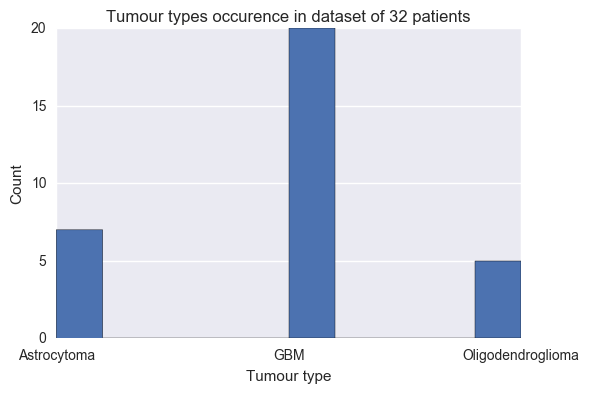

In [3]:
# Plot histogramme of tumour type in dataset (32 patients)

plt.hist(tumours['Disease'])
plt.xticks([0,1,2],['Astrocytoma', 'GBM', 'Oligodendroglioma'])
plt.xlabel('Tumour type')
plt.ylabel('Count')
plt.title('Tumour types occurence in dataset of 32 patients')
plt.show()

<img style="float:left" src='Average survival length per tumour types.png'>

<img src='Features distributions according to tumour types.png'>

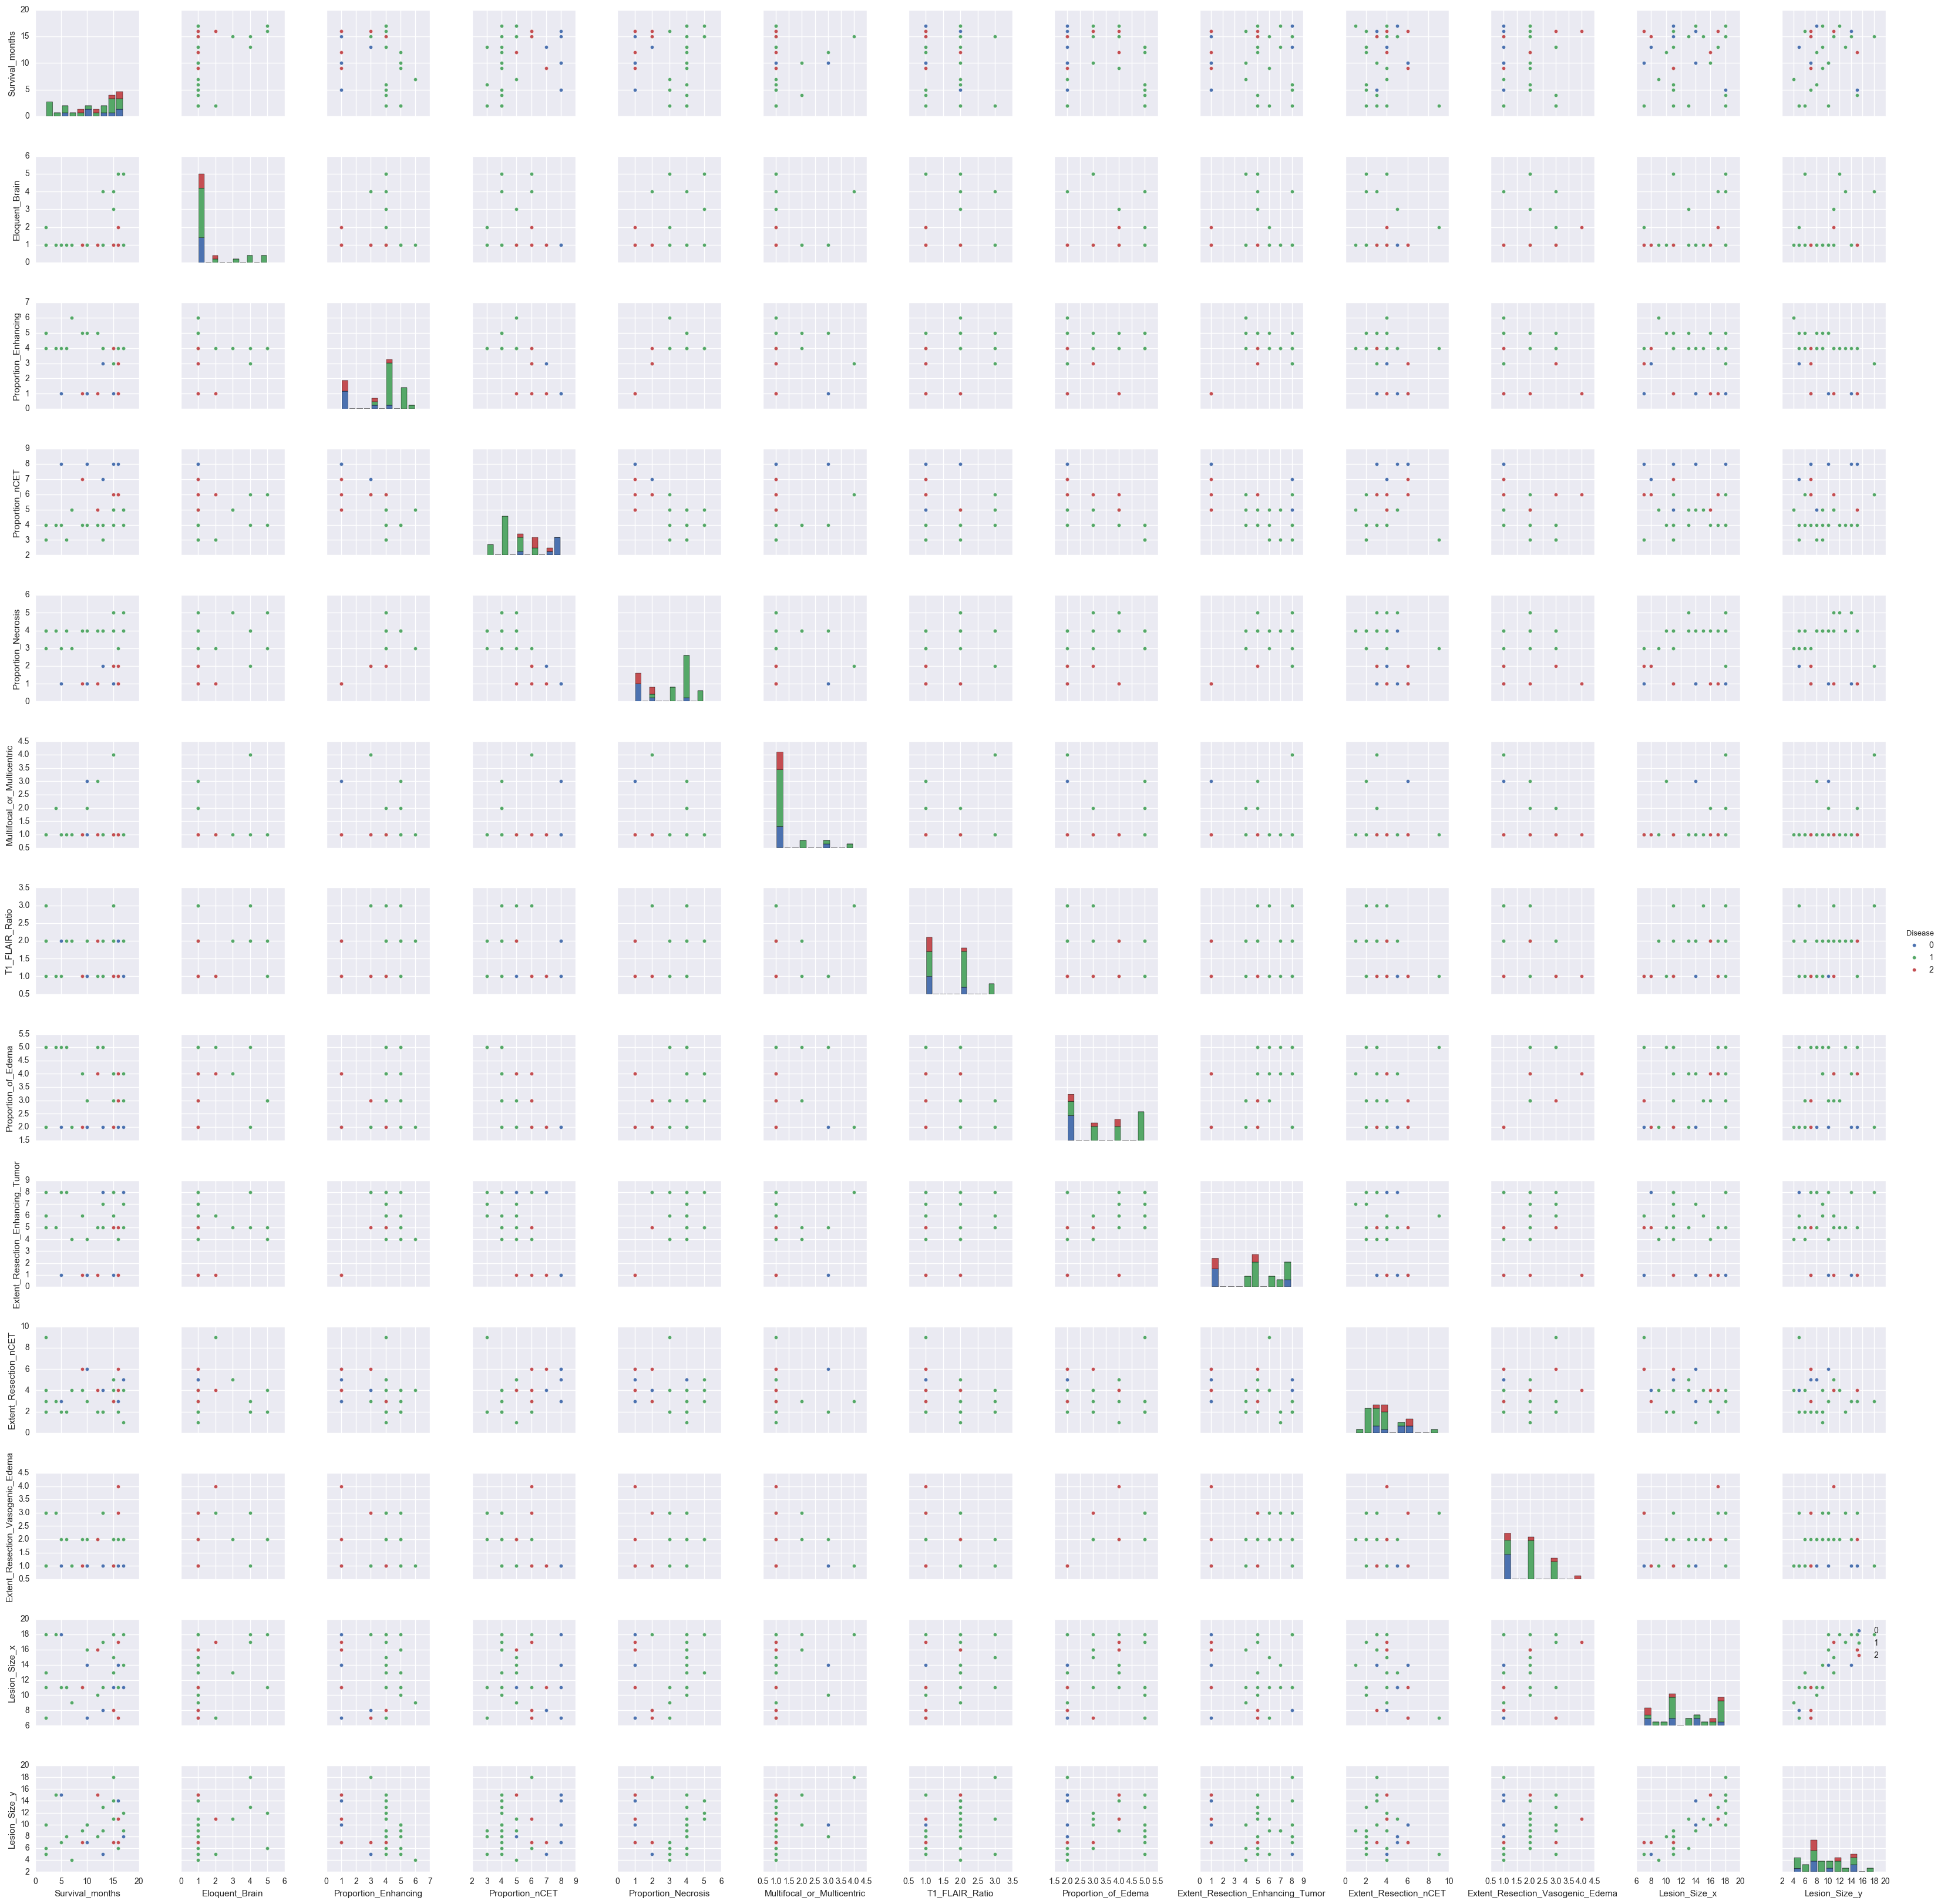

In [14]:
# Plot relations between variables and display tumour types

sns.pairplot(tumours, hue='Disease', hue_order=[0,1,2], vars=['Survival_months',
                                            'Eloquent_Brain','Proportion_Enhancing','Proportion_nCET',
                                            'Proportion_Necrosis','Multifocal_or_Multicentric','T1_FLAIR_Ratio',
                                            'Proportion_of_Edema','Extent_Resection_Enhancing_Tumor',
                                            'Extent_Resection_nCET','Extent_Resection_Vasogenic_Edema',
                                            'Lesion_Size_x', 'Lesion_Size_y'])
plt.legend()
plt.show()

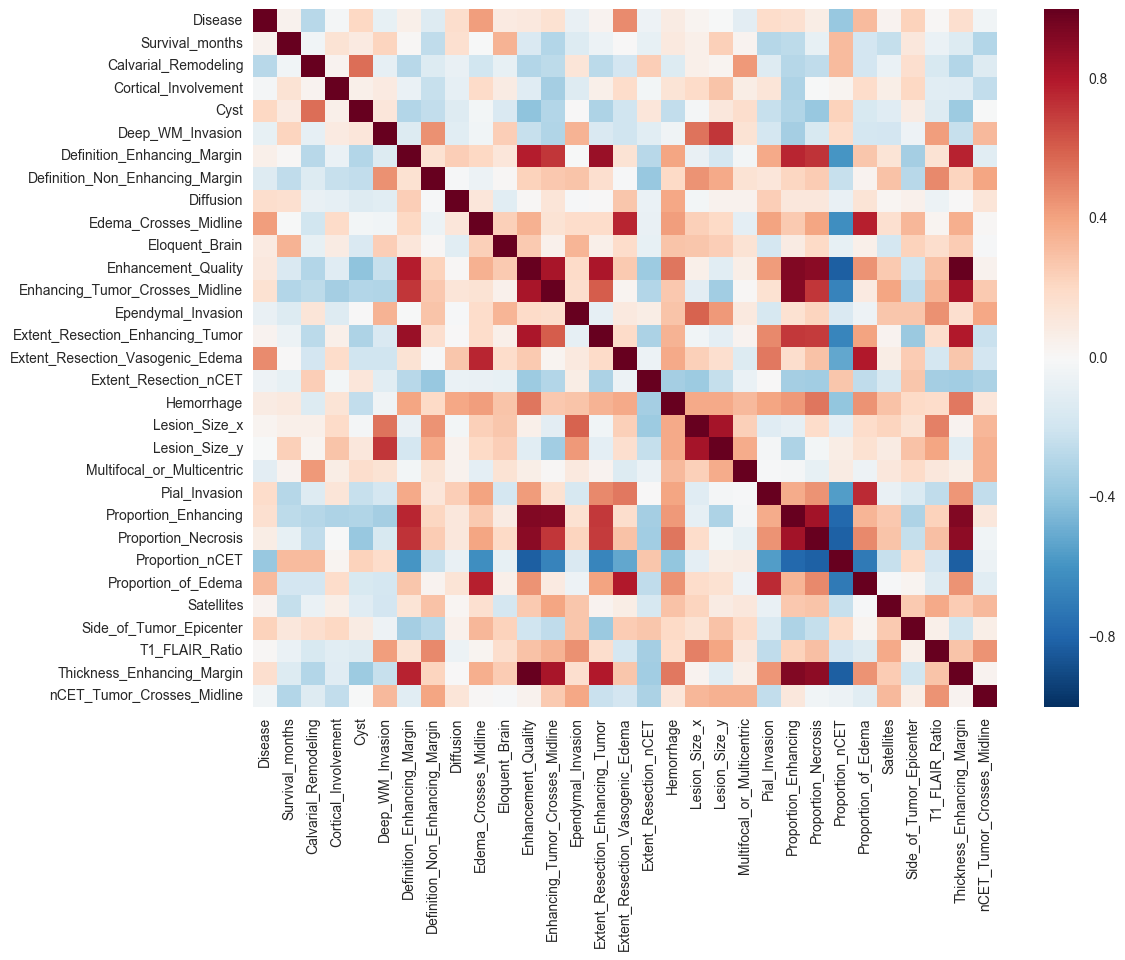

In [15]:
#Plot correlation heatmap

f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(tumours.corr())

Based on this first exploratory analysis, the tumor type ('Disease') doesn't seem to be particularly correlated to any specific features (there seems to be a slight correlation to edema features and nCET).  
Some features such as Lesion_size_x and Lesion_size_y or Proportions of enhancing tissue, necrosis and nCET seem to be strongly correlated. Therefore we will apply some techniques such as Lasso, PCA and LDA to try and reduce the influence of correlated features.

<a id='Part4'></a>

## 4. Studying feature importance with PCA

In [3]:
from sklearn.preprocessing import MinMaxScaler

X = tumours.drop(['Sample', 'Disease', 'Survival_months', 'Tumor_Location'], axis=1)
X_cols = X.columns
X = MinMaxScaler().fit_transform(X)
X = pd.DataFrame(X, columns=X_cols)
X.head()

,Calvarial_Remodeling,Cortical_Involvement,Cyst,Deep_WM_Invasion,Definition_Enhancing_Margin,Definition_Non_Enhancing_Margin,Diffusion,Edema_Crosses_Midline,Eloquent_Brain,Enhancement_Quality,Enhancing_Tumor_Crosses_Midline,Ependymal_Invasion,Extent_Resection_Enhancing_Tumor,Extent_Resection_Vasogenic_Edema,Extent_Resection_nCET,Hemorrhage,Lesion_Size_x,Lesion_Size_y,Multifocal_or_Multicentric,Pial_Invasion,Proportion_Enhancing,Proportion_Necrosis,Proportion_nCET,Proportion_of_Edema,Satellites,Side_of_Tumor_Epicenter,T1_FLAIR_Ratio,Thickness_Enhancing_Margin,nCET_Tumor_Crosses_Midline
0,0.0,1.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.500,0.0,0.363636,0.214286,0.0,0.0,0.0,0.00,1.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.5,0.0,1.000000,0.5,0.5,1.0,0.5,1.0,0.571429,0.333333,0.500,1.0,0.545455,0.500000,0.0,1.0,0.6,1.00,0.4,0.666667,0.0,1.0,0.5,1.0,0.0
2,0.0,1.0,0.0,0.0,0.5,0.0,0.000000,0.0,0.0,1.0,0.5,1.0,1.000000,0.000000,0.500,0.0,0.363636,0.285714,0.0,0.0,0.6,0.75,0.4,0.000000,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.5,0.0,0.000000,0.5,0.0,1.0,0.5,0.0,0.857143,0.333333,0.000,0.0,0.636364,0.357143,0.0,0.0,0.6,0.75,0.4,0.666667,0.0,1.0,0.5,1.0,0.0
4,0.0,1.0,0.0,1.0,0.5,1.0,0.000000,0.5,1.0,1.0,0.5,1.0,0.571429,0.333333,0.375,0.0,1.000000,0.571429,0.0,0.0,0.6,1.00,0.2,0.333333,0.0,0.0,0.5,1.0,0.0


In [41]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X)

pd.DataFrame(np.cumsum([round(i*100, 2) for i in pca.explained_variance_ratio_]), index=range(1,30), columns=['Cumulative % of Variance Explained']).head(10)

,Cumulative % of Variance Explained
1,30.74
2,47.93
3,59.78
4,67.76
5,73.62
6,78.13
7,81.67
8,84.97
9,87.79
10,90.27


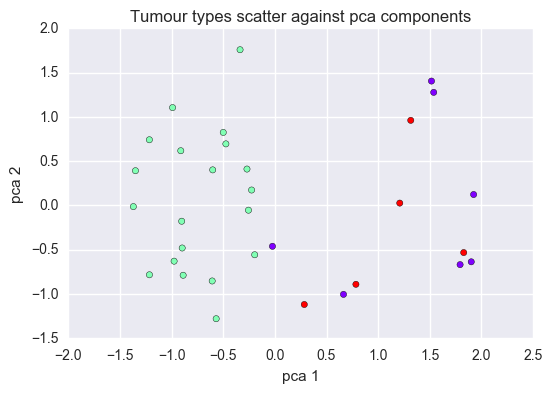

In [42]:
X_pca = PCA(n_components=2).fit_transform(X)

plt.scatter(X_pca[:,0], X_pca[:,1], c=tumours['Disease'], cmap='rainbow')
plt.xlabel('pca 1')
plt.ylabel('pca 2')
plt.title('Tumour types scatter against pca components')
plt.show()

The first two PCA components only account for 48% of the variance explained and we can see that with these two components only it would be difficult to distinguish between atrocytomas and oligodendrogliomas (pca1 > 0). Moreover in our case, PCA doesn't allows us to extract less features from the original images so we will not be using it in any further analysis.

<a id='Part5'></a>

## 5. Building and training models on manually extracted features

In [4]:
y = tumours['Disease']

In [5]:
print 'Baseline accuracy:', y.value_counts()[1]/float(len(y))

Baseline accuracy: 0.625


In [81]:
# Store all model scores in a list of tuples to compare them
model_scores = []

<a id='Part5a'></a>

### a. Logistic Regression

In [82]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict

logreg = LogisticRegression()

print 'Cross validated accuracy scores logistic regression C=1, Ridge penalty:', cross_val_score(logreg, X, y, cv=3)
print 'Mean cross validated accuracy:', cross_val_score(logreg, X, y, cv=3).mean()

Cross validated accuracy scores logistic regression C=1, Ridge penalty: [ 0.83333333  0.63636364  0.77777778]
Mean cross validated accuracy: 0.749158249158


Optimise model with GridSearchCV

In [83]:
gs_logreg = GridSearchCV(logreg, {'C': [10e-5, 10e-4, 10e-3, 10e-2, 0.1, 1, 10, 100, 10e3], 'penalty':['l1','l2']})
gs_logreg.fit(X,y)

print 'Regression parameters:', gs_logreg.best_params_, '\n'

print 'Cross validated accuracy logistic regression C=10, Ridge penalty (optimised):', gs_logreg.best_score_

model_scores.append(('gs_logreg', gs_logreg.best_score_))

Regression parameters: {'penalty': 'l2', 'C': 10} 

Cross validated accuracy logistic regression C=10, Ridge penalty (optimised): 0.78125


In [84]:
from sklearn.metrics import classification_report, confusion_matrix

print confusion_matrix(y, cross_val_predict(gs_logreg.best_estimator_, X, y, cv=3))
print classification_report(y, cross_val_predict(gs_logreg.best_estimator_, X, y, cv=3))

[[ 3  1  3]
 [ 1 19  0]
 [ 2  0  3]]
             precision    recall  f1-score   support

          0       0.50      0.43      0.46         7
          1       0.95      0.95      0.95        20
          2       0.50      0.60      0.55         5

avg / total       0.78      0.78      0.78        32



<a id='Part5b'></a>

### b. KNN

In [85]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

print 'Cross validated accuracy scores KNN 5 neighbours:', cross_val_score(knn, X, y, cv=3)
print 'Mean cross validated accuracy:', cross_val_score(knn, X, y, cv=3).mean()

Cross validated accuracy scores KNN 5 neighbours: [ 0.83333333  0.72727273  0.66666667]
Mean cross validated accuracy: 0.742424242424


Optimise model with GridSearchCV

In [86]:
gs_knn = GridSearchCV(knn, {'n_neighbors': range(1, 11)})
gs_knn.fit(X,y)

print 'KNN parameters:', gs_knn.best_params_, '\n'

print 'Cross validated accuracy KNN 6 neighbours:', gs_knn.best_score_

model_scores.append(('gs_knn', gs_knn.best_score_))

KNN parameters: {'n_neighbors': 6} 

Cross validated accuracy KNN 6 neighbours: 0.8125


<a id='Part5c'></a>

### c. Random Forest

In [87]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()

print 'Cross validated accuracy scores random forest:', cross_val_score(rfc, X, y, cv=3)
print 'Mean cross validated accuracy:', cross_val_score(rfc, X, y, cv=3).mean()

Cross validated accuracy scores random forest: [ 0.75        0.72727273  0.66666667]
Mean cross validated accuracy: 0.751683501684


Optimise model with GridSearchCV

In [88]:
gs_rfc = GridSearchCV(rfc, {'n_estimators': range(5, 85, 5)})
gs_rfc.fit(X,y)

print 'Random forest parameters:', gs_rfc.best_params_, '\n'

print 'Cross validated accuracy Random Forest 15 estimators:', gs_rfc.best_score_

model_scores.append(('gs_rfc', gs_rfc.best_score_))

Random forest parameters: {'n_estimators': 25} 

Cross validated accuracy Random Forest 15 estimators: 0.875


In [89]:
print confusion_matrix(y, cross_val_predict(gs_rfc.best_estimator_, X, y, cv=3))
print classification_report(y, cross_val_predict(gs_rfc.best_estimator_, X, y, cv=3))

[[ 5  1  1]
 [ 2 18  0]
 [ 3  0  2]]
             precision    recall  f1-score   support

          0       0.50      0.57      0.53         7
          1       0.95      0.90      0.92        20
          2       0.60      0.60      0.60         5

avg / total       0.80      0.78      0.79        32



The optimised random forest model seems to be performing very well, in particular it classifies all the GBMs acurately.

<a id='Part5d'></a>

### d. LDA

In [90]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()

X_lda = lda.fit_transform(X, y)
lda.explained_variance_ratio_

array([  9.71632947e-01,   2.83670525e-02,   1.61840392e-32])

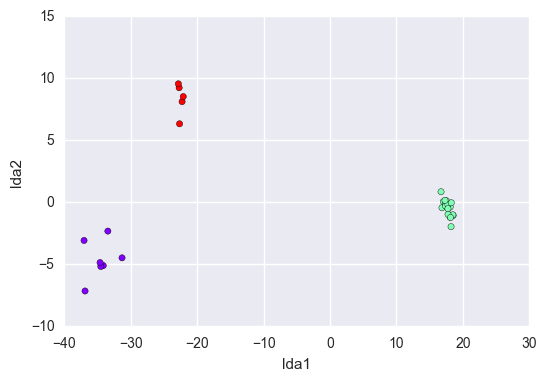

In [91]:
plt.scatter(X_lda[:,0], X_lda[:,1], c=y, cmap='rainbow')
plt.xlabel('lda1')
plt.ylabel('lda2')
plt.show()

In [92]:
print 'Cross validated accuracy scores LDA:', cross_val_score(lda, X, y, cv=3)
print 'Mean cross validated accuracy:', cross_val_score(lda, X, y, cv=3).mean()

model_scores.append(('LDA',cross_val_score(lda, X, y, cv=3).mean()))

Cross validated accuracy scores LDA: [ 0.83333333  0.72727273  0.22222222]
Mean cross validated accuracy: 0.594276094276


In [93]:
print confusion_matrix(y, cross_val_predict(lda, X, y, cv=3))
print classification_report(y, cross_val_predict(lda, X, y, cv=3))

[[ 4  1  2]
 [ 4 13  3]
 [ 1  1  3]]
             precision    recall  f1-score   support

          0       0.44      0.57      0.50         7
          1       0.87      0.65      0.74        20
          2       0.38      0.60      0.46         5

avg / total       0.70      0.62      0.65        32



LDA components seem to give a very accurate sepration of the three classes - with the first component explaining over 97% of the variance. However cross-validated predictions are quite unstable and can give poor results. It would be interesting to check this method against a bigger dataset once I extract the features from the rest of the dataset.

<a id='Part5e'></a>

### e. Naive Bayes

In [94]:
from sklearn.naive_bayes import MultinomialNB

nbm = MultinomialNB()

print 'Cross validated accuracy scores Naive Bayes:', cross_val_score(nbm, X, y, cv=3)
print 'Mean cross validated accuracy:', cross_val_score(nbm, X, y, cv=3).mean()

model_scores.append(('NBm', cross_val_score(nbm, X, y, cv=3).mean()))

Cross validated accuracy scores Naive Bayes: [ 0.75        0.72727273  0.77777778]
Mean cross validated accuracy: 0.751683501684


In [95]:
print confusion_matrix(y, cross_val_predict(nbm, X, y, cv=3))
print classification_report(y, cross_val_predict(nbm, X, y, cv=3))

[[ 4  2  1]
 [ 1 19  0]
 [ 2  2  1]]
             precision    recall  f1-score   support

          0       0.57      0.57      0.57         7
          1       0.83      0.95      0.88        20
          2       0.50      0.20      0.29         5

avg / total       0.72      0.75      0.72        32



<a id='Part5f'></a>

### f. Compare model scores

In [96]:
print 'Model scores', model_scores

Model scores [('gs_logreg', 0.78125), ('gs_knn', 0.8125), ('gs_rfc', 0.875), ('LDA', 0.59427609427609429), ('NBm', 0.75168350168350173)]


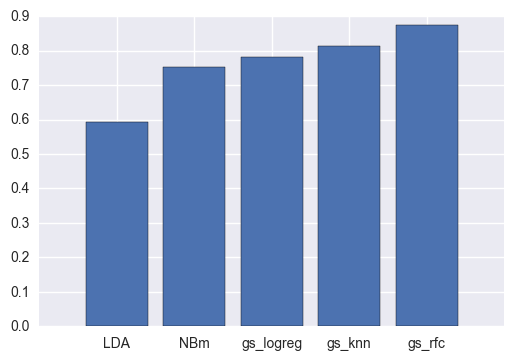

In [97]:
model_scores.sort(key=lambda tup: tup[1])

plt.bar(range(5), [tup[1] for tup in model_scores], align='center')
plt.xticks(range(5), [tup[0] for tup in model_scores])
plt.show()

<a id='Part6'></a>

## 6. Feature Selection

We will now try to limit our models to the 5 most relevant features to see if this improves their accuracies. We will first assess feature importances in our random forest model and then try to use SelectKBest and Recursive Feature Elimination techniques and compare the results.   
Since LDA and Naive Bayes gave worse results than the other three models in the first part, we will only consider logistic regression, KNN and random forest models for this analysis.

<a id='Part6a'></a>

### a. Random Forest Feature Importances

In [98]:
rfc_opt = gs_rfc.best_estimator_

In [99]:
# Feature importance in Random Forest model
rfc_top10 = pd.DataFrame({'columns':X.columns, 
                      'feature_importances_rfc':rfc_opt.feature_importances_}).sort_values('feature_importances_rfc', 
                                                                                            ascending=False).head(10)
rfc_top10

,columns,feature_importances_rfc
9,Enhancement_Quality,0.189819
22,Proportion_nCET,0.153062
27,Thickness_Enhancing_Margin,0.114970
20,Proportion_Enhancing,0.088466
14,Extent_Resection_nCET,0.071167
23,Proportion_of_Edema,0.053960
16,Lesion_Size_x,0.052259
7,Edema_Crosses_Midline,0.044019
21,Proportion_Necrosis,0.035218
11,Ependymal_Invasion,0.024953


#### Assess model performances on 3 most important features selected by the Random Forest model

In [100]:
X_3cols = X[['Proportion_nCET', 'Thickness_Enhancing_Margin', 'Enhancement_Quality']]

##### - Logistic Regression

In [101]:
print 'Cross validated accuracy scores logistic regression on RF 3 columns:', cross_val_score(gs_logreg.best_estimator_, X_3cols, y, cv=3)
print 'Mean cross validated accuracy:', cross_val_score(gs_logreg.best_estimator_, X_3cols, y, cv=3).mean()

model_scores.append(('Logreg_rf3', cross_val_score(gs_logreg.best_estimator_, X_3cols, y, cv=3).mean()))

Cross validated accuracy scores logistic regression on RF 3 columns: [ 0.75        0.90909091  0.88888889]
Mean cross validated accuracy: 0.849326599327


##### - KNN

In [102]:
print 'Cross validated accuracy scores knn on RF 3 columns:', cross_val_score(gs_knn.best_estimator_, X_3cols, y, cv=3)
print 'Mean cross validated accuracy:', cross_val_score(gs_knn.best_estimator_, X_3cols, y, cv=3).mean()

model_scores.append(('KNN_rf3', cross_val_score(gs_knn.best_estimator_, X_3cols, y, cv=3).mean()))

Cross validated accuracy scores knn on RF 3 columns: [ 0.75        0.81818182  0.88888889]
Mean cross validated accuracy: 0.819023569024


##### - Random Forest

In [103]:
print 'Cross validated accuracy scores random forest on 3 most important features:', cross_val_score(rfc_opt, X_3cols, y, cv=3)
print 'Mean cross validated accuracy:', cross_val_score(rfc_opt, X_3cols, y, cv=3).mean()

model_scores.append(('rfc_rf3', cross_val_score(rfc_opt, X_3cols, y, cv=3).mean()))

Cross validated accuracy scores random forest on 3 most important features: [ 0.91666667  0.90909091  0.88888889]
Mean cross validated accuracy: 0.904882154882


#### Compare model scores

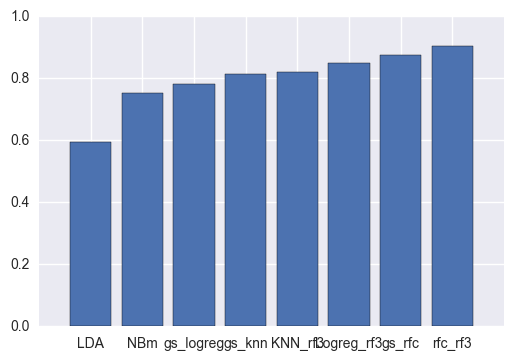

In [104]:
model_scores.sort(key=lambda tup: tup[1])

plt.bar(range(8), [tup[1] for tup in model_scores], align='center')
plt.xticks(range(8), [tup[0] for tup in model_scores])
plt.show()

<a id='Part6b'></a>

### b. SelectKBest

In [105]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif, k=5)
selected_data = selector.fit_transform(X, y)

kbest_columns = X.columns[selector.get_support()]
Xtbest = pd.DataFrame(selected_data, columns=kbest_columns)

# p-values of each feature in SelectKBest
SelectKBest_top10 = pd.DataFrame({'columns':X.columns, 'p_values':selector.pvalues_}).sort_values('p_values').head(10)
SelectKBest_top10

,columns,p_values
9,Enhancement_Quality,1.222770e-10
27,Thickness_Enhancing_Margin,7.099996e-10
22,Proportion_nCET,2.079979e-08
21,Proportion_Necrosis,6.455087e-08
20,Proportion_Enhancing,2.704213e-07
10,Enhancing_Tumor_Crosses_Midline,5.254509e-05
12,Extent_Resection_Enhancing_Tumor,1.535407e-03
15,Hemorrhage,1.547425e-03
23,Proportion_of_Edema,1.682849e-03
4,Definition_Enhancing_Margin,2.458544e-03


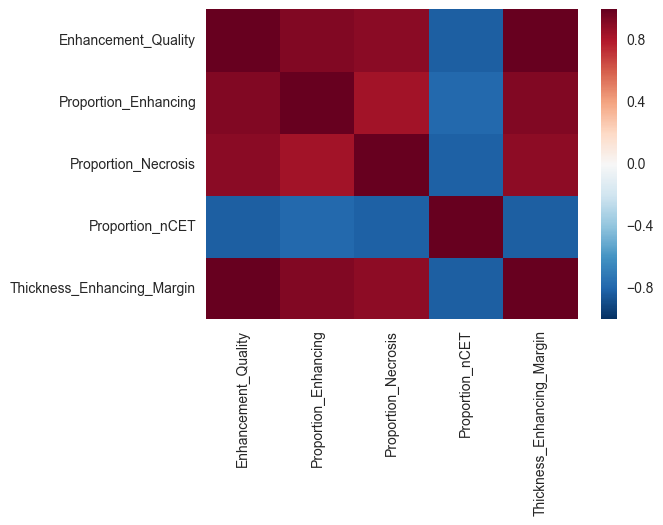

In [106]:
# Plot correlations between selected 5 features
sns.heatmap(tumours[kbest_columns].corr())

#### Assess model performances on SelectKBest features (n=5)

##### - Logistic Regression

In [107]:
print 'Cross validated accuracy scores logistic regression on KBest columns:', cross_val_score(gs_logreg.best_estimator_, Xtbest, y, cv=3)
print 'Mean cross validated accuracy:', cross_val_score(gs_logreg.best_estimator_, Xtbest, y, cv=3).mean()

model_scores.append(('Logreg_kbest', cross_val_score(gs_logreg.best_estimator_, Xtbest, y, cv=3).mean()))

Cross validated accuracy scores logistic regression on KBest columns: [ 0.75        0.90909091  0.88888889]
Mean cross validated accuracy: 0.849326599327


##### - KNN

In [108]:
print 'Cross validated accuracy scores knn on KBest columns:', cross_val_score(gs_knn.best_estimator_, Xtbest, y, cv=3)
print 'Mean cross validated accuracy:', cross_val_score(gs_knn.best_estimator_, Xtbest, y, cv=3).mean()

model_scores.append(('KNN_kbest', cross_val_score(gs_knn.best_estimator_, Xtbest, y, cv=3).mean()))

Cross validated accuracy scores knn on KBest columns: [ 0.75        0.81818182  0.88888889]
Mean cross validated accuracy: 0.819023569024


##### - Random Forests on KBest columns

In [109]:
print 'Cross validated accuracy scores random forest on KBest columns:', cross_val_score(gs_rfc.best_estimator_, Xtbest, y, cv=3)
print 'Mean cross validated accuracy:', cross_val_score(gs_rfc.best_estimator_, Xtbest, y, cv=3).mean()

model_scores.append(('rfc_kbest', cross_val_score(gs_rfc.best_estimator_, Xtbest, y, cv=3).mean()))

Cross validated accuracy scores random forest on KBest columns: [ 0.91666667  0.90909091  1.        ]
Mean cross validated accuracy: 0.941919191919


#### Compare model scores

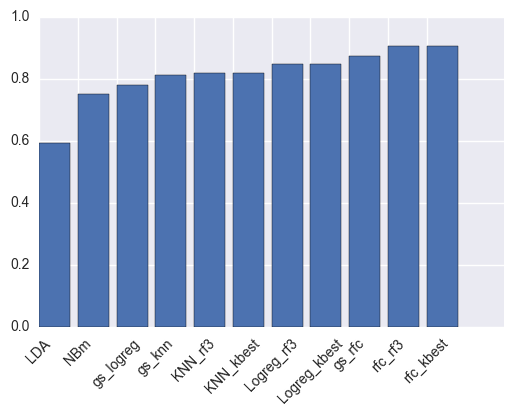

In [110]:
model_scores.sort(key=lambda tup: tup[1])

plt.bar(range(11), [tup[1] for tup in model_scores])
plt.xticks(range(11), [tup[0] for tup in model_scores], rotation=45)
plt.show()

Selecting only the 5 best columns improved the accuracy of the Random Forest model model. However since these 5 columns are correlated models might be overfitting.

<a id='Part6c'></a>

### c. Recursive Feature Elimination (RFE)

#### - Logistic Regression

In [111]:
from sklearn.feature_selection import RFE

# Features rank in logistic regression RFE
rfe_logreg = RFE(gs_logreg.best_estimator_, n_features_to_select=1)
rfe_logreg.fit(X, y)

RFE_logreg_top10 = pd.DataFrame({'columns':X.columns, 
                              'ranking_RFE_logreg':rfe_logreg.ranking_}).sort_values('ranking_RFE_logreg').head(10)
RFE_logreg_top10

,columns,ranking_RFE_logreg
9,Enhancement_Quality,1
22,Proportion_nCET,2
13,Extent_Resection_Vasogenic_Edema,3
15,Hemorrhage,4
26,T1_FLAIR_Ratio,5
2,Cyst,6
0,Calvarial_Remodeling,7
23,Proportion_of_Edema,8
10,Enhancing_Tumor_Crosses_Midline,9
25,Side_of_Tumor_Epicenter,10


In [112]:
# Define X with only 5 bets features
rfe_logreg = RFE(gs_logreg.best_estimator_, n_features_to_select=5)
X_rfe_logreg = rfe_logreg.fit_transform(X, y)
rfe_logreg_columns = X.columns[rfe_logreg.get_support()]
X_rfe_logreg = pd.DataFrame(X_rfe_logreg, columns=rfe_logreg_columns)

In [113]:
print 'Cross validated accuracy scores RFE logistic regression:', cross_val_score(rfe_logreg, X, y, cv=3)
print 'Mean cross validated accuracy:', cross_val_score(rfe_logreg, X, y, cv=3).mean()

model_scores.append(('logreg_rfe', cross_val_score(rfe_logreg, X, y, cv=3).mean()))

Cross validated accuracy scores RFE logistic regression: [ 0.83333333  0.81818182  0.44444444]
Mean cross validated accuracy: 0.698653198653


#### Random Forest

In [114]:
# Features rank in random forest RFE
rfe_rf = RFE(rfc_opt, n_features_to_select=1)
rfe_rf.fit(X, y)

RFE_rfc_top10 = pd.DataFrame({'columns':X.columns, 
                              'ranking_RFE_rfc':rfe_rf.ranking_}).sort_values('ranking_RFE_rfc').head(10)
RFE_rfc_top10

,columns,ranking_RFE_rfc
27,Thickness_Enhancing_Margin,1
22,Proportion_nCET,2
9,Enhancement_Quality,3
12,Extent_Resection_Enhancing_Tumor,4
14,Extent_Resection_nCET,5
13,Extent_Resection_Vasogenic_Edema,6
16,Lesion_Size_x,7
21,Proportion_Necrosis,8
4,Definition_Enhancing_Margin,9
10,Enhancing_Tumor_Crosses_Midline,10


In [115]:
# Define X with only 5 best features
rfe_rf = RFE(rfc_opt, n_features_to_select=5)
X_rfe_rf = rfe_rf.fit_transform(X, y)

rfe_rf_columns = X.columns[rfe_rf.get_support()]
X_rfe_rf = pd.DataFrame(X_rfe_rf, columns=rfe_rf_columns)

In [116]:
print 'Cross validated accuracy scores RFE random forest:', cross_val_score(rfe_rf, X, y, cv=3)
print 'Mean cross validated accuracy:', cross_val_score(rfe_rf, X, y, cv=3).mean()

model_scores.append(('rfc_rfe', cross_val_score(rfe_rf, X, y, cv=3).mean()))

Cross validated accuracy scores RFE random forest: [ 0.91666667  0.90909091  0.88888889]
Mean cross validated accuracy: 0.867845117845


<a id='Part6d'></a>

### d. Compare feature importances and model scores

In [117]:
# Feature importances according to the three techniques: Random Forest, SelectKBest and RFE on Random Forest
pd.DataFrame({'rfc_top10':rfc_top10['columns'].values, 
              'SelectKBest_top10':SelectKBest_top10['columns'].values,
              'RFE_logreg_top10':RFE_logreg_top10['columns'].values,
              'RFE_rfc_top10':RFE_rfc_top10['columns'].values})

,RFE_logreg_top10,RFE_rfc_top10,SelectKBest_top10,rfc_top10
0,Enhancement_Quality,Thickness_Enhancing_Margin,Enhancement_Quality,Enhancement_Quality
1,Proportion_nCET,Proportion_nCET,Thickness_Enhancing_Margin,Proportion_nCET
2,Extent_Resection_Vasogenic_Edema,Enhancement_Quality,Proportion_nCET,Thickness_Enhancing_Margin
3,Hemorrhage,Extent_Resection_Enhancing_Tumor,Proportion_Necrosis,Proportion_Enhancing
4,T1_FLAIR_Ratio,Extent_Resection_nCET,Proportion_Enhancing,Extent_Resection_nCET
5,Cyst,Extent_Resection_Vasogenic_Edema,Enhancing_Tumor_Crosses_Midline,Proportion_of_Edema
6,Calvarial_Remodeling,Lesion_Size_x,Extent_Resection_Enhancing_Tumor,Lesion_Size_x
7,Proportion_of_Edema,Proportion_Necrosis,Hemorrhage,Edema_Crosses_Midline
8,Enhancing_Tumor_Crosses_Midline,Definition_Enhancing_Margin,Proportion_of_Edema,Proportion_Necrosis
9,Side_of_Tumor_Epicenter,Enhancing_Tumor_Crosses_Midline,Definition_Enhancing_Margin,Ependymal_Invasion


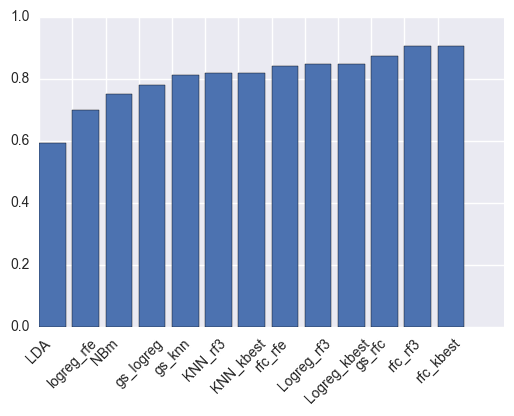

In [118]:
model_scores.sort(key=lambda tup: tup[1])

plt.bar(range(13), [tup[1] for tup in model_scores])
plt.xticks(range(13), [tup[0] for tup in model_scores], rotation=45)
plt.show()

Selected features accross the four techniques are very similar; in particular the top 3 features for Random Forest, SelectKBest and RF RFE are the same. They are also consistent with the box plots included in Part 3 of this notebook where we could see that these specific features seemed to differ between tumour types.  
   
With regards to model performance, Random Forest seems to be performing better than all other models regardless of feature selection. The model has similar scores on 3 features and 5 features. However since we only have 32 samples in our dataset so far, the model is probably overfitting here but might not generalise wellon another dataset with only 3 features. Therefore we will keep the 5 best features in our model.

<a id='Part7'></a>

## 7. Cross-validated results of chosen model: Random forest (n=25) with 5 best features

Random forest on SelectKBest (n=5) features gives the best cross-validated accuracy. Therefore this is the model we will be using.    
Its cross validated accuracy, confusion matrix and classification report are shown below. We also added a ROC Curve of the model if it only had to predict whether the tumour was GBM or not (binary output).  
   
Please note that at this stage we are unable to provide an unbiased estimation of future performance as our dataset is too small to be splitted into training/validation and test sets - the below scores include a selection bias. Unbiased performance will be assessed once relevant features have been extracted from the remaining 98 patient images for which we do not have a record of manually extracted features (please see Part 8).

In [120]:
acc_cv_mean = cross_val_score(rfc_opt, Xtbest, y, cv=3).mean()
acc_cv_std = cross_val_score(rfc_opt, Xtbest, y, cv=3).std()

print 'Accuracy:', round(acc_cv_mean,4), '+/-', round(acc_cv_std,4)

Accuracy: 0.9049 +/- 0.0117


In [121]:
print 'Predicted probabilities of tumour types:'
pd.DataFrame(cross_val_predict(gs_rfc.best_estimator_, Xtbest, y, cv=3, method='predict_proba'), 
             columns=['0 - Astrocytoma', '1 - GBM', '2 - Oligodendroglioma']).join(tumours['Disease'])

Predicted probabilities of tumour types:


,0 - Astrocytoma,1 - GBM,2 - Oligodendroglioma,Disease
0,0.880000,0.000000,0.12,0
1,0.000000,1.000000,0.00,1
2,0.000000,1.000000,0.00,0
3,0.000000,1.000000,0.00,1
4,0.000000,1.000000,0.00,1
5,0.000000,1.000000,0.00,1
6,0.200000,0.520000,0.28,1
7,0.120000,0.320000,0.56,2
8,0.000000,1.000000,0.00,1
9,0.040000,0.040000,0.92,2


In [122]:
print 'Confusion matrix'
pd.DataFrame(confusion_matrix(y, cross_val_predict(gs_rfc.best_estimator_, Xtbest, y, cv=3)), 
             columns = ['predicted_Astrocytoma', 'predicted_GBM', 'predicted_Oligodendroglioma'],
             index = ['actual_Astrocytoma', 'actual_GBM', 'actual_Oligodendroglioma'])

Confusion matrix


,predicted_Astrocytoma,predicted_GBM,predicted_Oligodendroglioma
actual_Astrocytoma,5,1,1
actual_GBM,0,20,0
actual_Oligodendroglioma,1,0,4


In [123]:
print 'Classification report'
print classification_report(y, cross_val_predict(gs_rfc.best_estimator_, Xtbest, y, cv=3))

Classification report
             precision    recall  f1-score   support

          0       1.00      0.71      0.83         7
          1       0.95      1.00      0.98        20
          2       0.83      1.00      0.91         5

avg / total       0.94      0.94      0.93        32



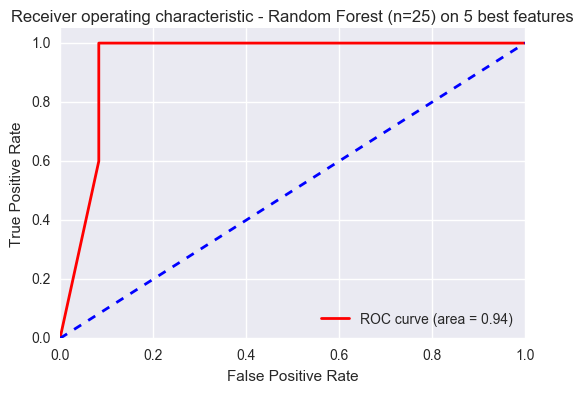

In [124]:
# Plot ROC curve of GBM vs non-GBM (two classes output instead of three)

y_bin = [1 if i==1 else 0 for i in y]
y_bin_score = cross_val_predict(gs_rfc.best_estimator_, Xtbest, y_bin, cv=3, method='predict_proba')[:,1]

from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_bin, y_bin_score)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='r',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='b', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - Random Forest (n=25) on 5 best features')
plt.legend(loc="lower right")
plt.show()

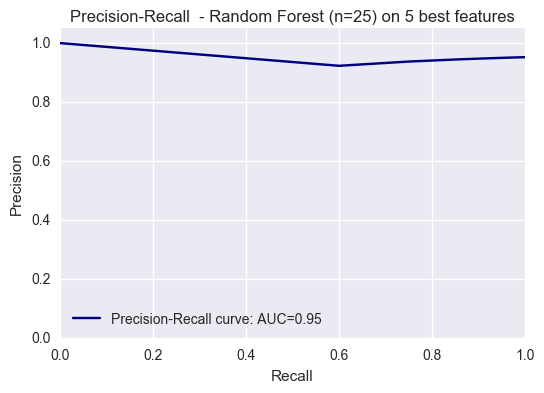

In [146]:
# Plot precision-recall curve of GBM vs non-GBM

from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_bin, y_bin_score)
average_precision = average_precision_score(y_bin, y_bin_score)

plt.plot(recall, precision, color='navy', 
         label='Precision-Recall curve: AUC={0:0.2f}'.format(average_precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall  - Random Forest (n=25) on 5 best features')
plt.legend(loc="lower left")
plt.show()

<a id='Part8'></a>

## 8. Extraction of MRI scans 
(please see separate notebook for the whole workflow - the below is only a summary of the best working technique I found so far)

The aim of this section is to automatically extract the 5 best features from the same 32 patients we studied previously (for which we used manually extracted features) and test our model with these features.  
If this model gives good results, we will then extend it to the remaining 95 patients for whom we only have a target but no manually extracted features.

For image extraction and analysis we will use the SimpleITK library.  
SimpleITK is a simplified interface to the Insight Segmentation and Registration Toolkit (ITK). ITK is a templated C++ library of image processing algorithms and frameworks for biomedical and other applications. SimpleITK provides an easy to use interface to ITK’s algorithms and is particularly useful to segment and analyse medical images.
  
*Ref:* Lowekamp BC et al.The Design of SimpleITK.*Frontiers in Neuroinformatics.*2013;7:45

In [3]:
import SimpleITK

In [4]:
# int label to assign to the segmented tumour
labelTumour = 1

In [5]:
# Define a function to display one ITK image

def sitk_show(img, title=None, margin=0.0, dpi=40, axis='off'):
    nda = SimpleITK.GetArrayFromImage(img)
    spacing = img.GetSpacing()
    figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi
    extent = (0, nda.shape[1]*spacing[1], nda.shape[0]*spacing[0], 0)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

    plt.set_cmap("gray")
    ax.imshow(nda,extent=extent,interpolation=None)
    ax.axis(axis)
    
    if title:
        plt.title(title)
    
    plt.show()

In [6]:
# Define a function to display the 4 sequences T1, T2, FLAIR and T1 GD

sequence_names = ['T1', 'T2', 'FLAIR', 'T1 GD']

def sitk_show_4seq(imgs, margin=0.05, dpi=40, axis='off', size=(5,5)):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=size)
        
    for ax, img, seq in zip([ax1,ax2,ax3,ax4], imgs, sequence_names):
        nda = SimpleITK.GetArrayFromImage(img)
        spacing = img.GetSpacing()
        figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi
        extent = (0, nda.shape[1]*spacing[1], nda.shape[0]*spacing[0], 0)

        plt.set_cmap("gray")
        ax.imshow(nda,extent=extent,interpolation=None)
        ax.set_title(seq)
        ax.axis(axis)
    
    fig.show()

In [7]:
# Define a function to display several slices of the 4 sequences 

def sitk_show_slices(imgs, margin=0.05, dpi=40, axis='off', size=(10,10), first_slice=8, last_slice=14):
    fig, im = plt.subplots(4, last_slice - first_slice +1, figsize=size)
        
    for ax, img, seq in zip([im[0],im[1],im[2],im[3]], imgs, sequence_names):
        for i in range(first_slice, last_slice+1):
            nda = SimpleITK.GetArrayFromImage(img[:,:,i])
            spacing = img[:,:,i].GetSpacing()
            figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi
            extent = (0, nda.shape[1]*spacing[1], nda.shape[0]*spacing[0], 0)

            plt.set_cmap("gray")
            ax[i-first_slice].imshow(nda,extent=extent,interpolation=None)
            ax[i-first_slice].set_title(seq+', slice'+str(i))
            ax[i-first_slice].axis(axis)
    
    fig.show()

In [8]:
# Load in DICOM images for 1 patient

# Load in the 4 main sequences: T1, T2, FLAIR and post-IV (= T1 GD)
PathDicom_T1 = "./REMBRANDT/900-00-1961/AX_T1/"
PathDicom_T2 = "./REMBRANDT/900-00-1961/AX_T2/"
PathDicom_FLAIR = "./REMBRANDT/900-00-1961/AX_FLAIR/"
PathDicom_T1GD = "./REMBRANDT/900-00-1961/AX_T1_GD/"

# Load in image series
def import_img_series(path):
    reader = SimpleITK.ImageSeriesReader()
    filenamesDICOM = reader.GetGDCMSeriesFileNames(path)
    reader.SetFileNames(filenamesDICOM)
    return reader.Execute()

img_T1_Original = import_img_series(PathDicom_T1)
img_T2_Original = import_img_series(PathDicom_T2)
img_FLAIR_Original = import_img_series(PathDicom_FLAIR)
img_T1GD_Original = import_img_series(PathDicom_T1GD)

img_4seq = [img_T1_Original, img_T2_Original, img_FLAIR_Original, img_T1GD_Original]

/Users/chloe/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


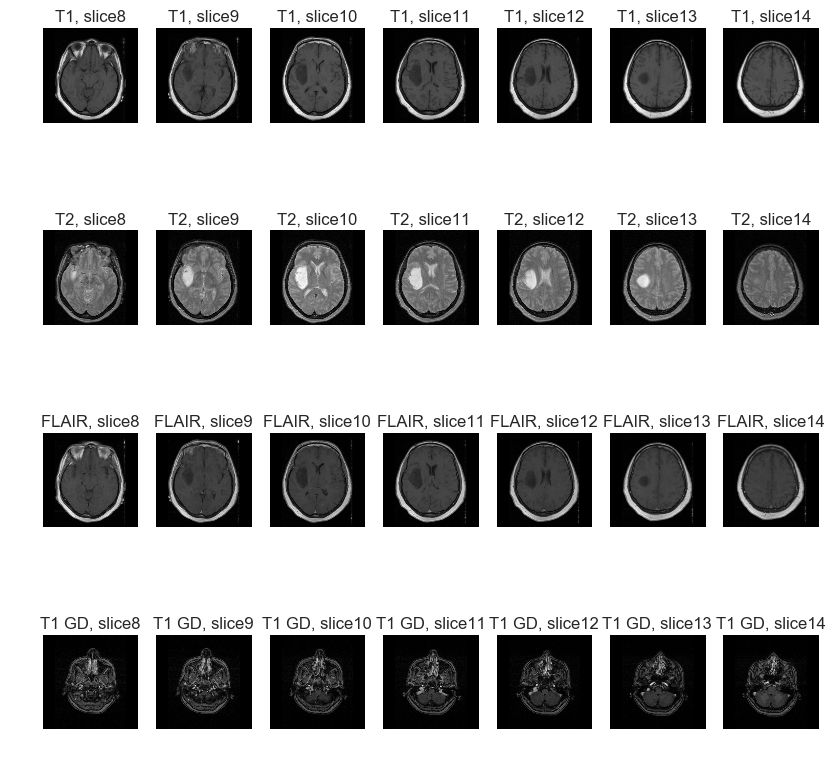

In [9]:
sitk_show_slices(img_4seq)

From this first display of the sequences, we can already see that images are misaligned - especially T1 GD. As we will see in part a, images are also of different sizes, origins and spacings so we will need to reshape them before being able to use them.

<a id='Part8a'></a>

### a. Reshape images

T1
Size: (256, 256, 20)
Origin: (-105.0097885131836, -92.68102264404297, -69.89035034179688)
Spacing: (0.859375, 0.859375, 7.5) 

T2
Size: (512, 512, 20)
Origin: (-105.0097885131836, -93.85526275634766, -70.89044952392578)
Spacing: (0.4296875, 0.4296875, 7.5) 

FLAIR
Size: (256, 256, 20)
Origin: (-105.59687042236328, -87.98433685302734, -71.65164947509766)
Spacing: (0.859375, 0.859375, 7.5) 

T1 GD
Size: (512, 512, 60)
Origin: (-142.64187622070312, -131.4876251220703, -79.95494842529297)
Spacing: (0.546875, 0.546875, 3.0) 



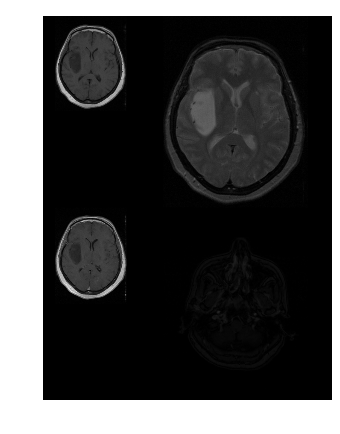

In [10]:
# Print image sizes and show images using the Tile function (agregates images in real size)
for seq, img in zip(sequence_names, img_4seq):
    print seq
    print 'Size:', img.GetSize()
    print 'Origin:', img.GetOrigin()
    print 'Spacing:', img.GetSpacing(), '\n'
    
sitk_show(SimpleITK.Tile(img_T1_Original[:,:,10], img_T2_Original[:,:,10], 
                         img_FLAIR_Original[:,:,10], img_T1GD_Original[:,:,10], (2,2,0)),
         dpi=200)

In [11]:
# Define resample filter to match T1 image dimension and settings
resample = SimpleITK.ResampleImageFilter()
resample.SetReferenceImage(img_T1_Original)
resample.SetInterpolator(SimpleITK.sitkBSpline)

# Resize all other three images
img_T2_Resized = resample.Execute(img_T2_Original)
img_FLAIR_Resized = resample.Execute(img_FLAIR_Original)
img_T1GD_Resized = resample.Execute(img_T1GD_Original)

# Define list of all 4 resized images
img_4seq_resized = [img_T1_Original, img_T2_Resized, img_FLAIR_Resized, img_T1GD_Resized]

# Define list of images of slice 10 of the 4 sequences (2D images)
img_4seq_slice10 = [img_T1_Original[:,:,10], img_T2_Resized[:,:,10], 
                    img_FLAIR_Resized[:,:,10], img_T1GD_Resized[:,:,10]]

T1
Size: (256, 256, 20)
Origin: (-105.0097885131836, -92.68102264404297, -69.89035034179688)
Spacing: (0.859375, 0.859375, 7.5) 

T2
Size: (256, 256, 20)
Origin: (-105.0097885131836, -92.68102264404297, -69.89035034179688)
Spacing: (0.859375, 0.859375, 7.5) 

FLAIR
Size: (256, 256, 20)
Origin: (-105.0097885131836, -92.68102264404297, -69.89035034179688)
Spacing: (0.859375, 0.859375, 7.5) 

T1 GD
Size: (256, 256, 20)
Origin: (-105.0097885131836, -92.68102264404297, -69.89035034179688)
Spacing: (0.859375, 0.859375, 7.5) 



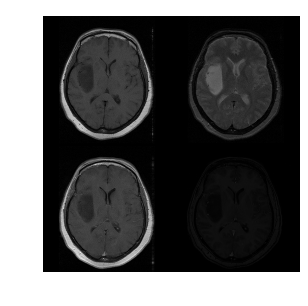

In [12]:
# Show that images are now all aligned

for seq, img in zip(sequence_names, img_4seq_resized):
    print seq
    print 'Size:', img.GetSize()
    print 'Origin:', img.GetOrigin()
    print 'Spacing:', img.GetSpacing(), '\n'
    
sitk_show(SimpleITK.Tile(img_4seq_slice10, (2,2,0)),
         dpi=200)

<a id='Part8b'></a>

### b. Remove noise

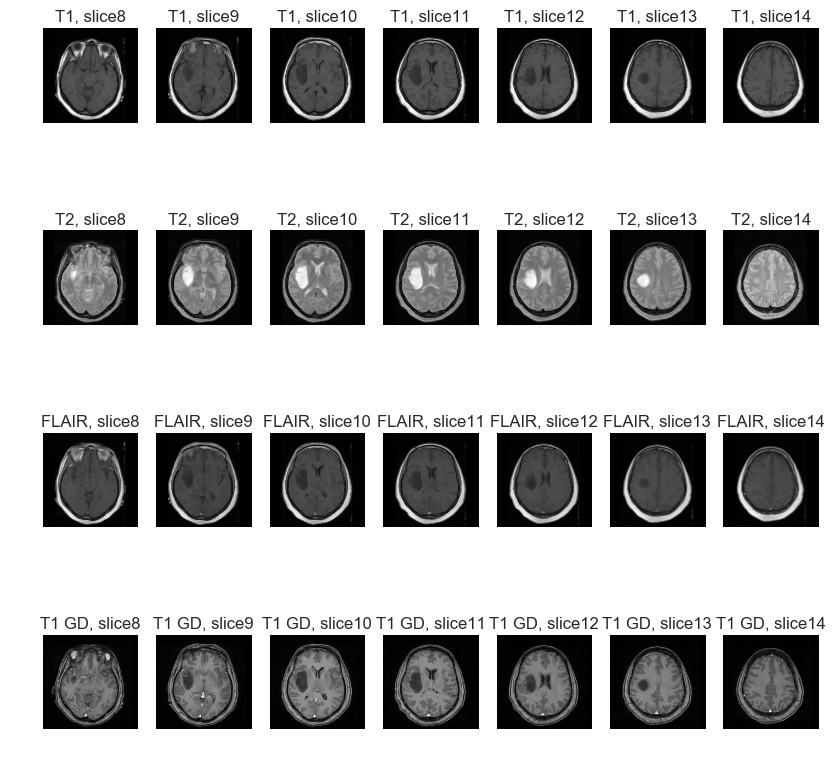

In [13]:
# Apply a curvature-flow filter to smoothen the image (get rid of image noise)

imgSmooth_4seq = []

for img in img_4seq_resized:
    imgSmooth_4seq.append(SimpleITK.CurvatureFlow(image1=img,
                                    timeStep=0.125,
                                    numberOfIterations=5))

sitk_show_slices(imgSmooth_4seq)

<a id='Part8c'></a>

### c. Initial tumour segmentation with thresholding (in 3D)
(This is only possible on T2 and FLAIR images as the tumour appears bright on these images; contrary to T1 images on which it appears dark)

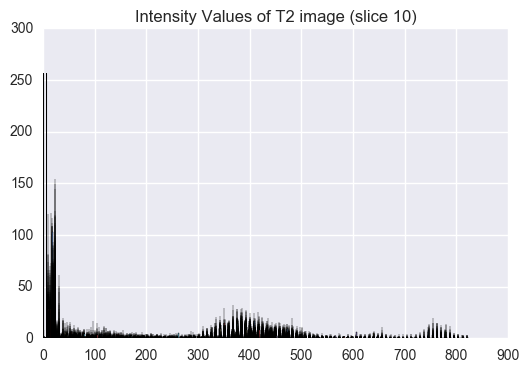

In [118]:
# Get histogram of T2 image intensities (slice 10)

intensity_values_T2 = SimpleITK.GetArrayFromImage(imgSmooth_4seq[1][:,:,10])

plt.hist(intensity_values_T2, bins=100)
plt.title("Intensity Values of T2 image (slice 10)")
plt.show()

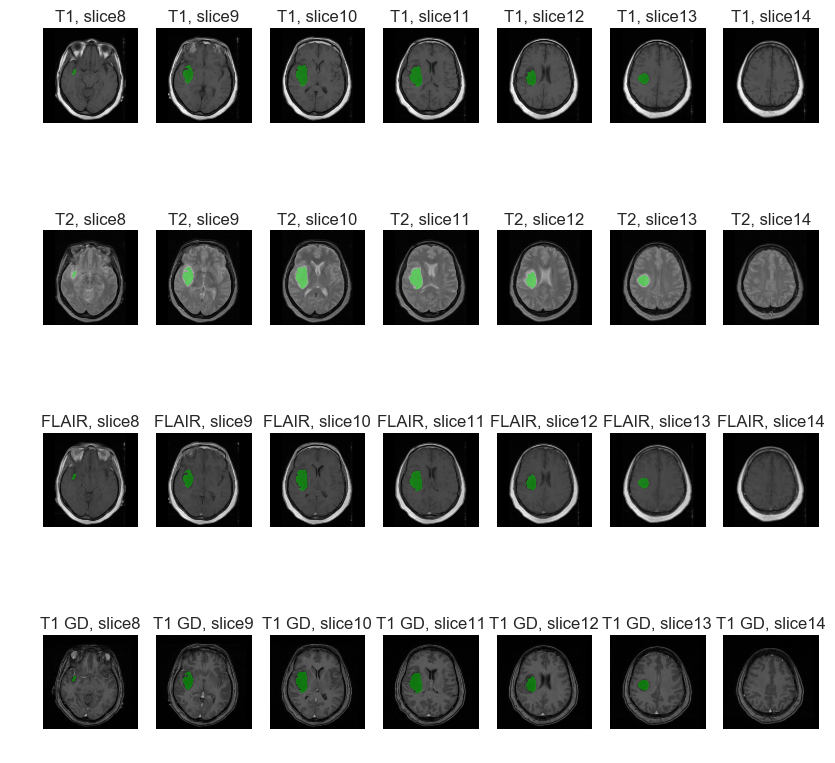

In [14]:
# Tumour segmentation with Binary Thresholding on T2 imaging

tumour_thres = SimpleITK.BinaryThreshold(imgSmooth_4seq[1], lowerThreshold=700, upperThreshold=900, 
                                            insideValue=labelTumour, outsideValue=0)

# Rescale images intensity and change pixel type so they can be diplayed on the same image as tumour_thres
imgSmoothInt_4seq = []
for img in imgSmooth_4seq:
    imgSmoothInt_4seq.append(SimpleITK.Cast(SimpleITK.RescaleIntensity(img), tumour_thres.GetPixelID()))

    
sitk_show_slices([SimpleITK.LabelOverlay(i, tumour_thres) for i in imgSmoothInt_4seq])

This doesn't isolate the whole tumour perfectly but it will allow us to extract an intial tumour location. This will be used to first select a slice which contains the largest tumour area (we will complete our analysis and tumour feature extraction in 2D only) and then to compute a confidence connected filter to isolate the tumour more accurately in 2D.

<a id='Part8d'></a>

### d. Selection of slice with largest tumour area

In [15]:
# Define initial slice to start looking for tumour
slice_max = 0

# Initialise filter to analyse tumour dimension in each slice
label_shape_analysis_thres = SimpleITK.LabelShapeStatisticsImageFilter()
label_shape_analysis_thres.SetBackgroundValue(0)
label_shape_analysis_thres.Execute(tumour_thres[:,:,slice_max])

# Check that tumour was detected in slice
if np.count_nonzero(SimpleITK.GetArrayFromImage(tumour_thres[:,:,slice_max])) > 0:
    # If so, compute number of pixels in tumour in this slice
    slice_pixels = label_shape_analysis_thres.GetNumberOfPixels(labelTumour)
else:
    slice_pixels = 0

# Loop through the rest of the slices and assign the slice with largest tumour area to slice_max
for s in range(slice_max+1, 20):
    if np.count_nonzero(SimpleITK.GetArrayFromImage(tumour_thres[:,:,s])) > 0:
        label_shape_analysis_thres.Execute(tumour_thres[:,:,s])
        pix = label_shape_analysis_thres.GetNumberOfPixels(labelTumour)
        if pix > slice_pixels:
            (slice_max, slice_pixels) = (s, pix)

print 'Selected slice:', slice_max

Selected slice: 10


<a id='Part8e'></a>

### e. Refined segmentation with Confidence Connected filter on T2 and FLAIR images (in 2D)

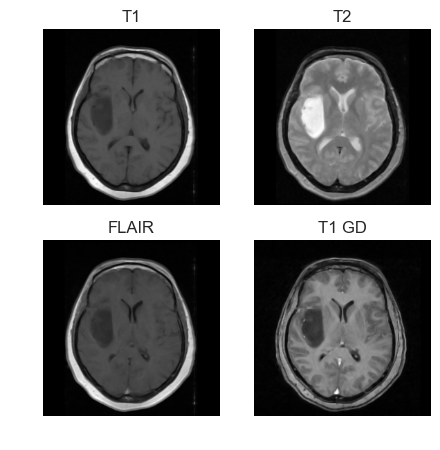

In [16]:
# Define image slice in all four sequences
imgSmooth_4seq_slice10 = [imgSmooth_4seq[i][:,:,slice_max] for i in range(4)]

sitk_show_4seq(imgSmooth_4seq_slice10, size=(5,5))

# Find coordinates of points inside tumour on T2 and FLAIR images - MANUALLY
# These will be used as seeds for the VectorConfidenceConnected filter that we will use to isolate the tumour

# Here we maximise pixel values at relevant coordinates so they appear white on the image
# Vary coordinates until all relevant points are found and appear white

lstSeeds = [(80, 115), (75, 125), (85, 130), (80,145), (95,125)]

flair_locs = SimpleITK.Image(imgSmooth_4seq_slice10[2])

for pt in lstSeeds:
    flair_locs[pt[0],pt[1]] = 2000

sitk_show(flair_locs, dpi=100)

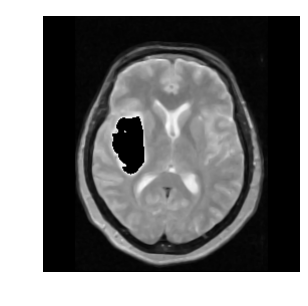

In [17]:
# Find coordinates of points inside tumour on T2 image - AUTOMATICALLY
# These will be used as seeds for the Confidence Connected filter that we will use to isolate the tumour

# In this case we will use all the point that were identified by the initial thresholding
seeds_auto = np.argwhere(SimpleITK.GetArrayFromImage(tumour_thres[:,:,slice_max])==labelTumour)

# Inverse dimensions as the function GetArryFromImage returns vertical image values in lines and horizontal image values in columns 
for seed in seeds_auto:
    seed[0], seed[1] = seed[1], seed[0]

# Show seeds on the image by setting their pixel values to 0
seeds_locs = SimpleITK.Image(imgSmooth_4seq_slice10[1])
for pt in seeds_auto:
    seeds_locs.SetPixel(pt[0],pt[1], 0)
    
sitk_show(seeds_locs, dpi=100)

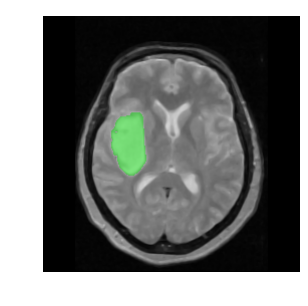

In [26]:
# Refine tumour segmentation based on list of seeds previously assigned with Confidence Connected filter
imgTumour = SimpleITK.ConfidenceConnected(image1=imgSmooth_4seq_slice10[1], 
                                               seedList=seeds_auto,
                                               numberOfIterations=3,
                                               multiplier=4,
                                               replaceValue=labelTumour)

# Display resulting segmentation on top of composed image
imgSmoothInt_T2 = SimpleITK.Cast(SimpleITK.RescaleIntensity(imgSmooth_4seq_slice10[1]), 
                                           imgTumour.GetPixelID())

sitk_show(SimpleITK.LabelOverlay(imgSmoothInt_T2, imgTumour), dpi=100)

<a id='Part8f'></a>

### f. Extract tumour VASARI features

<a id='Part8f1'></a>

#### (i) Tumour dimensions and Side of tumour epicentre

In [103]:
# Get tumour dimensions

label_shape_analysis = SimpleITK.LabelShapeStatisticsImageFilter()
label_shape_analysis.SetBackgroundValue(0)
label_shape_analysis.Execute(imgTumour)

print 'T2 image Confidence Connected tumour dimensions'
print 'Centre location:', imgTumour.TransformPhysicalPointToIndex(label_shape_analysis.GetCentroid(labelTumour))
print 'Ellipsoid diameters:', label_shape_analysis.GetEquivalentEllipsoidDiameter(labelTumour)
print 'Number of pixels in tumour:', label_shape_analysis.GetNumberOfPixels(labelTumour)

T2 image Confidence Connected tumour dimensions
Centre location: (86L, 127L)
Ellipsoid diameters: (29.377692918107225, 54.15745175113214)
Number of pixels in tumour: 1692


In [30]:
# Define fonction to convert tumour diameters to originally encoded labels from 1 to 18
def size_label(x):
    j = round(x,1)
    if j<5:
        return 1
    elif j<=7.5:
        return 2
    elif j<=12.5:
        return 3
    elif j<=17.5:
        return 4
    elif j<=22.5:
        return 5
    elif j<=27.5:
        return 6
    elif j<=32.5:
        return 7
    elif j<=37.5:
        return 8
    elif j<=42.5:
        return 9
    elif j<=47.5:
        return 10
    elif j<=52.5:
        return 11
    elif j<=57.5:
        return 12
    elif j<=62.5:
        return 13
    elif j<=67.5:
        return 14
    elif j<=72.5:
        return 15
    elif j<=77.5:
        return 16
    elif j<=80:
        return 17
    else:
        return 18

# Define function to return largest encoded diametre first
def convert_size_to_label((x,y)):
    (a,b)=(0,0)
    # Largest returned diameter first 
    if x>y:
        (a,b)=(x,y)
    else:
        (a,b)=(y,x)
    # Assign labels to each diameter
    return (size_label(a),size_label(b))

In [31]:
# Define fonction to convert tumour centre location to originally encoded label: 3 if left, 1 if right, 2 if centre
# This refers to the side of the brain so it will appear on the opposite side on the image (mirror effect)
# /!\ HOW TO CHECK IF BILATERAL??

def convert_centre_location_to_side_label((x,y)):
    if int(x)>128:
        return 3
    elif int(x)<128:
        return 1
    else:
        return 2

In [33]:
# Compare with manually calculated dimensions (stored in tumours dataframe)

print 'Automatically computed features'
print 'X dimension:', convert_size_to_label(label_shape_analysis.GetEquivalentEllipsoidDiameter(labelTumour))[0]
print 'Y dimension:', convert_size_to_label(label_shape_analysis.GetEquivalentEllipsoidDiameter(labelTumour))[1]
print 'Side of tumour epicentre:', convert_centre_location_to_side_label(imgTumour.TransformPhysicalPointToIndex(label_shape_analysis.GetCentroid(labelTumour)))

print '-------'

print 'Manually extracted features (from tumours dataframe)'
print 'X dimension:', tumours.loc[tumours['Sample']=='900_00_1961', 'Lesion_Size_x'].values[0]
print 'Y dimension:', tumours.loc[tumours['Sample']=='900_00_1961', 'Lesion_Size_y'].values[0]
print 'Side of tumour epicentre:', tumours.loc[tumours['Sample']=='900_00_1961', 'Side_of_Tumor_Epicenter'].values[0]

 Automatically computed features
X dimension: 12
Y dimension: 7
Side of tumour epicentre: 1
-------
Manually extracted features (from tumours dataframe)
X dimension: 11
Y dimension: 7
Side of tumour epicentre: 1


The automatically extracted parameters seem to match the manually extracted ones.   
X dimension is a bit bigger in the automated features - we will see if this makes a difference in the model.

In [104]:
# Define functions to get tumour sizes and side of epicentre

def Lesion_size_x(imgTumour):
    label_shape_analysis_T2 = SimpleITK.LabelShapeStatisticsImageFilter()
    label_shape_analysis_T2.SetBackgroundValue(0)
    label_shape_analysis_T2.Execute(imgTumour[1])
    return convert_size_to_label(label_shape_analysis_T2.GetEquivalentEllipsoidDiameter(labelTumour))[0]

def Lesion_size_y(imgTumour):
    label_shape_analysis_T2 = SimpleITK.LabelShapeStatisticsImageFilter()
    label_shape_analysis_T2.SetBackgroundValue(0)
    label_shape_analysis_T2.Execute(imgTumour[1])
    return convert_size_to_label(label_shape_analysis_T2.GetEquivalentEllipsoidDiameter(labelTumour))[1]

def Side_of_tumor_epicenter(imgTumour):
    label_shape_analysis_T2 = SimpleITK.LabelShapeStatisticsImageFilter()
    label_shape_analysis_T2.SetBackgroundValue(0)
    label_shape_analysis_T2.Execute(imgTumour[1])
    epicentre_index = imgTumour[1].TransformPhysicalPointToIndex(label_shape_analysis.GetCentroid(labelTumour))
    return convert_centre_location_to_side_label(epicentre_index)

<a id='Part8f2'></a>

#### (ii) T1/FLAIR ratio
Tumor feature summary. (Use T2 if FLAIR is not provided).
 - 1 = Expansive: size of pre-contrast T1 abnormality (exclusive of signal intensity) approximates size of FLAIR abnormality. 
 - 2 = Mixed: Size of T1 abnormality moderately less than FLAIR envelope
 - 3 = Infiltrative: Size of pre-contrast T1 abnormality much smaller than size of FLAIR abnormality.

In [60]:
def convert_T1FlairRatio_to_label((T1Size, FlairSize)):
    ratio =  float(FlairSize) / float(T1Size)
    if round(ratio) == 1:
        return 1
    elif round(ratio) <= 2:
        return 2
    elif round(ratio) > 2:
        return 3
    else:
        return 0

The seeds that we generated to isolate the tumour initially were based on T2 image. But the tumour appears larger in T2 than T1 so we will create a new list of seeds for T1 and T1 GD images by removing the outside seeds from our intial selection.

In [50]:
# Generate sub-list of seeds

xMin = np.min(seeds_auto[:,0])
xMax = np.max(seeds_auto[:,0])
yMin = np.min(seeds_auto[:,1])
yMax = np.max(seeds_auto[:,1])

seedsT1 = []

for seed in seeds_auto:
    if seed[0]>xMin+10 and seed[0]<xMax-10 and seed[1]>yMin+10 and seed[1]<yMax-10:
        seedsT1.append([seed[0], seed[1]])

print 'Original size of list of seeds:', np.size(seeds_auto)
print 'Size of sublist of seeds:', np.size(seedsT1)

Original size of list of seeds: 2736
Size of sublist of seeds: 714


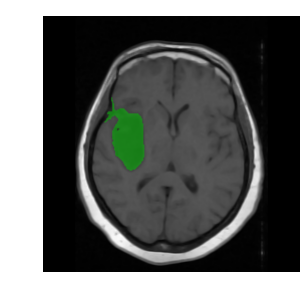

Number of pixels in T1 image tumour: 1583
Physical Size: 1169.08569336


In [57]:
# Tumour segmentation on T1 image
imgTumourT1 = SimpleITK.ConfidenceConnected(image1=imgSmooth_4seq_slice10[0], 
                                              seedList=seedsT1,
                                              numberOfIterations=3,
                                              multiplier=2,
                                              replaceValue=labelTumour)

# Display resulting segmentation
imgSmoothIntT1 = SimpleITK.Cast(SimpleITK.RescaleIntensity(imgSmooth_4seq_slice10[0]), 
                                           imgTumourT1.GetPixelID())
sitk_show(SimpleITK.LabelOverlay(imgSmoothIntT1, imgTumourT1), dpi=100)


# Compute tumour size (number of pixels)
label_shape_analysis_T1 = SimpleITK.LabelShapeStatisticsImageFilter()
label_shape_analysis_T1.SetBackgroundValue(0)
label_shape_analysis_T1.Execute(imgTumourT1)
print 'Number of pixels in T1 image tumour:', label_shape_analysis_T1.GetNumberOfPixels(labelTumour)
print 'Physical Size:', label_shape_analysis_T1.GetPhysicalSize(labelTumour)

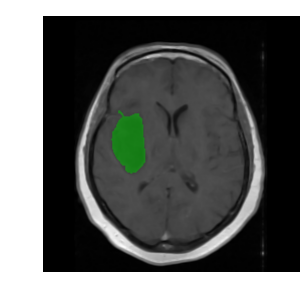

Number of pixels in FLAIR image tumour: 1534


In [65]:
# Tumour segmentation on FLAIR image
imgTumourFlair = SimpleITK.ConfidenceConnected(image1=imgSmooth_4seq_slice10[2], 
                                              seedList=seedsT1,
                                              numberOfIterations=5,
                                              multiplier=2.8,
                                              replaceValue=labelTumour)

# Display resulting segmentation
imgSmoothIntFlair = SimpleITK.Cast(SimpleITK.RescaleIntensity(imgSmooth_4seq_slice10[2]), 
                                           imgTumourFlair.GetPixelID())
sitk_show(SimpleITK.LabelOverlay(imgSmoothIntFlair, imgTumourFlair), dpi=100)


# Compute tumour size (number of pixels)
label_shape_analysis_Flair = SimpleITK.LabelShapeStatisticsImageFilter()
label_shape_analysis_Flair.SetBackgroundValue(0)
label_shape_analysis_Flair.Execute(imgTumourFlair)
print 'Number of pixels in FLAIR image tumour:', label_shape_analysis_Flair.GetNumberOfPixels(labelTumour)

In [66]:
# Compute T1/FLAIR ratio feature and compare it with manually extracted feature (stored in tumours dataframe)

print 'Automatically computed feature'
print convert_T1FlairRatio_to_label((label_shape_analysis_T1.GetPhysicalSize(labelTumour),
                                    label_shape_analysis_Flair.GetPhysicalSize(labelTumour)))

print '-------'

print 'Manually extracted features (from tumours dataframe)'
print tumours.loc[tumours['Sample']=='900_00_1961', 'T1_FLAIR_Ratio'].values[0]

Automatically computed feature
1
-------
Manually extracted features (from tumours dataframe)
1


In [102]:
def T1_FLAIR_ratio(imgTumour):
    # Analyse tumour size in T1 image
    label_shape_analysis_Flair = SimpleITK.LabelShapeStatisticsImageFilter()
    label_shape_analysis_Flair.SetBackgroundValue(0)
    label_shape_analysis_Flair.Execute(imgTumour[0])
    
    # Analyse tumour size in FLAIR image
    label_shape_analysis_Flair = SimpleITK.LabelShapeStatisticsImageFilter()
    label_shape_analysis_Flair.SetBackgroundValue(0)
    label_shape_analysis_Flair.Execute(imgTumour[2])
    
    return convert_T1FlairRatio_to_label((label_shape_analysis_T1.GetPhysicalSize(labelTumour),
                                    label_shape_analysis_Flair.GetPhysicalSize(labelTumour)))

<a id='Part8f3'></a>

#### (iii) Enhancement Quality
Qualitative degree of contrast enhancement is defined as having all or portions of the tumor that demonstrate significantly higher signal on the T1 GD images compared to T1 images.
 - 1 = None 
 - 2 = Mild/Minimal 
 - 3 = Marked/Avid

In [67]:
def convert_enhancement_to_label(T1Int, T1GDInt):
    ratio =  float(T1GDInt) / float(T1Int)
    if round(ratio) <= 1:
        return 1
    elif round(ratio) <= 1.5:
        return 2
    else:
        return 3

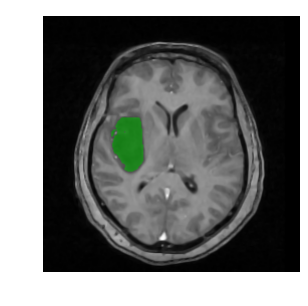

In [74]:
# Tumour segmentation on T1 GD image
imgTumourT1GD = SimpleITK.ConfidenceConnected(image1=imgSmooth_4seq_slice10[3], 
                                              seedList=seedsT1,
                                              numberOfIterations=3,
                                              multiplier=2.8,
                                              replaceValue=labelTumour)

# Display resulting segmentation
imgSmoothIntT1GD = SimpleITK.Cast(SimpleITK.RescaleIntensity(imgSmooth_4seq_slice10[3]), 
                                           imgTumourT1GD.GetPixelID())

sitk_show(SimpleITK.LabelOverlay(imgSmoothIntT1GD, imgTumourT1GD), dpi=100)

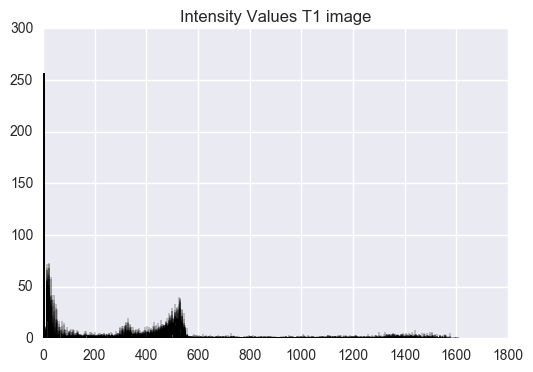

In [25]:
intensity_values_T1 = SimpleITK.GetArrayFromImage(imgSmooth_4seq_slice10[0])

plt.hist(intensity_values_T1, bins=256)
plt.title("Intensity Values T1 image")
plt.show()

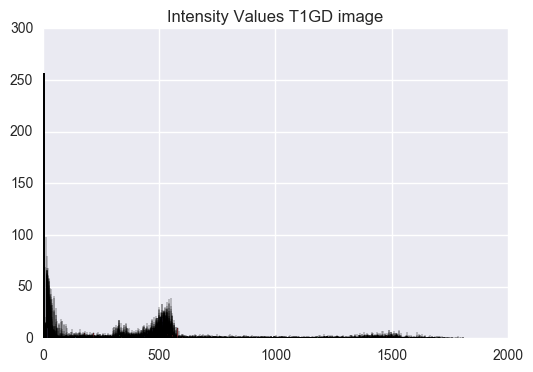

In [26]:
intensity_values_T1GD = SimpleITK.GetArrayFromImage(imgSmooth_4seq_slice10[3])

plt.hist(intensity_values_T1GD, bins=256)
plt.title("Intensity Values T1GD image")
plt.show()

In [75]:
# The tumour image intensity values are only 0s and 1s
arrayTumourT1GD = SimpleITK.GetArrayFromImage(imgTumourT1GD)
dfTumourT1GD = pd.DataFrame(arrayTumourT1GD)
dfTumourT1GD[86].value_counts()

0    202
1     54
Name: 86, dtype: int64

In [76]:
arrayT1GD = SimpleITK.GetArrayFromImage(imgSmooth_4seq_slice10[3])

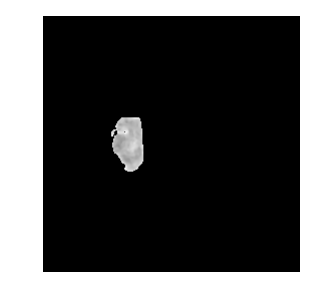

In [77]:
# Multiply the T1GC image with the tumour image in order to get a tumour image with its original intensity levels

arrayTumourIntT1GD = np.multiply(arrayT1GD, arrayTumourT1GD)

imgTumourIntT1GD = SimpleITK.GetImageFromArray(arrayTumourIntT1GD)

sitk_show(imgTumourIntT1GD, dpi=100)

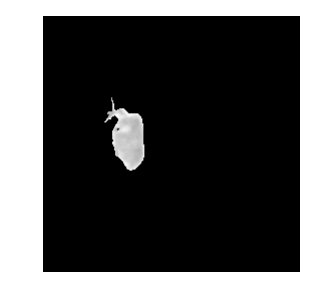

In [78]:
# Perform the same operation on T1 image (isolate tumour with original intensities)

arrayTumourT1 = SimpleITK.GetArrayFromImage(imgTumourT1)
arrayT1 = SimpleITK.GetArrayFromImage(imgSmooth_4seq_slice10[0])

arrayTumourIntT1 = np.multiply(arrayT1, arrayTumourT1)

imgTumourIntT1 = SimpleITK.GetImageFromArray(arrayTumourIntT1)

sitk_show(imgTumourIntT1, dpi=100)

In [79]:
# Compare tumour maximum intensities between T1 image and T1GD image

T1MaxInt = arrayTumourIntT1.max()
T1GDMaxInt = arrayTumourIntT1GD.max()

print 'T1 max intensity:', T1MaxInt
print 'T1 GD max intensity:', T1GDMaxInt 

T1 max intensity: 417.799493309
T1 GD max intensity: 66.9591100317


In [80]:
print 'Automatically computed feature'
print convert_enhancement_to_label(T1MaxInt, T1GDMaxInt)

print '-------'

print 'Manually extracted feature (from tumours dataframe)'
print tumours.loc[tumours['Sample']=='900_00_1961', 'Enhancement_Quality'].values[0]

Automatically computed feature
1
-------
Manually extracted feature (from tumours dataframe)
1


In [110]:
# Define function to return label from a list of arrays of tumour intensities in all sequences

def enhancement_quality(arrayTumourInt):
    T1MaxInt = arrayTumourInt[0].max()
    T1GDMaxInt = arrayTumourInt[3].max()
    return convert_enhancement_to_label(T1MaxInt, T1GDMaxInt)

<a id='Part8f4'></a>

#### (iv) Proportion Enhancing
What proportion of the entire tumor is enhancing? (Assuming that the entire abnormality may be comprised of: (1) an enhancing component, (2) a non- enhancing component, (3) a necrotic component and (4) a edema component.)
 - 1 = N/A 
 - 2 = None (0%) 
 - 3 = <5%
 - 4 = 6-33%  
 - 5 = 34-67%
 - 6 = 68-95%
 - 7 = >95%
 - 8 = All (100%) 
 - 9 = Indeterminate

In [81]:
def convert_prop_enhancing_to_label(T1GD_prop):
    if T1GD_prop == 0:
        return 2
    elif T1GD_prop <= 0.05:
        return 3
    elif T1GD_prop <= 0.33:
        return 4
    elif T1GD_prop <= 0.67:
        return 5
    elif T1GD_prop <= 0.95:
        return 6
    elif T1GD_prop < 1:
        return 7
    else:
        return 8

In [112]:
# Define function to return label from a list of arrays of tumour intensities in all sequences

def proportion_enhancing(arrayTumourInt):
    if enhancement_quality(arrayTumourInt) == 1:
        return 1
    else:
        pixels_max_in_T1GD = np.sum(np.where((arrayTumourInt[3] - arrayTumourInt[0])>0, True, False))
        total_pix_T1GD = np.count_nonzero(arrayTumourInt[3])
        T1GD_prop = float(pixels_max_in_T1GD) / float(total_pix_T1GD)
        return convert_prop_enhancing_to_label(T1GD_prop)

In [113]:
print 'Automatically computed feature'
print proportion_enhancing([arrayTumourIntT1, _, _, arrayTumourIntT1GD])

print '-------'

print 'Manually extracted feature (from tumours dataframe)'
print tumours.loc[tumours['Sample']=='900_00_1961', 'Proportion_Enhancing'].values[0]

Automatically computed feature
1
-------
Manually extracted feature (from tumours dataframe)
1


<a id='Part8f5'></a>

#### (v) Proportion nCET
What proportion of the entire tumor is non-enhancing?  
Non-enhancing tumor is defined as regions of T2 hyperintensity (less than the intensity of cerebrospinal fluid, with corresponding T1 hypointensity) that are associated with mass effect and architectural distortion, including blurring of the gray-white interface.
 - 1 = N/A 
 - 2 = None (0%) 
 - 3 = <5%
 - 4 = 6-33%  
 - 5 = 34-67%
 - 6 = 68-95%
 - 7 = >95%
 - 8 = All (100%) 
 - 9 = Indeterminate

In [88]:
def proportion_nCET(arrayTumourIntT2):
    # /!\ Edema signal is higher than nCET => add other condition!! (Check on other images!)
    T2_prop = float(np.sum(np.where(arrayTumourIntT2>=550, True, False)))/float(np.count_nonzero(arrayTumourIntT2))
    if T2_prop == 0:
        return 2
    elif T2_prop <= 0.05:
        return 3
    elif T2_prop <= 0.33:
        return 4
    elif T2_prop <= 0.67:
        return 5
    elif T2_prop <= 0.95:
        return 6
    elif T2_prop < 1:
        return 7
    else:
        return 8

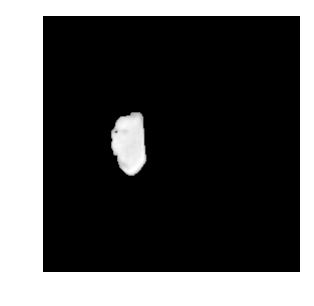

In [90]:
# Isolate tumour with original intensities on T2 image

arrayTumourT2 = SimpleITK.GetArrayFromImage(imgTumour)
arrayT2 = SimpleITK.GetArrayFromImage(imgSmooth_4seq_slice10[1])

arrayTumourIntT2 = np.multiply(arrayT2, arrayTumourT2)

imgTumourIntT2 = SimpleITK.GetImageFromArray(arrayTumourIntT2)

sitk_show(imgTumourIntT2, dpi=100)

In [114]:
# Define hyperintensity as >550??
print 'Number of pixels in tumour T2:', np.count_nonzero(arrayTumourIntT2)

print 'Number of hyperintense pixels:', np.sum(np.where(arrayTumourIntT2>=550, True, False))

T2_prop = float(np.sum(np.where(arrayTumourIntT2>=550, True, False)))/float(np.count_nonzero(arrayTumourIntT2))
print 'Proportion:', T2_prop

Number of pixels in tumour T2: 1665
Number of hyperintense pixels: 1665
Proportion: 1.0


In [91]:
print 'Automatically computed feature'
print proportion_nCET(arrayTumourIntT2)

print '-------'

print 'Manually extracted feature (from tumours dataframe)'
print tumours.loc[tumours['Sample']=='900_00_1961', 'Proportion_nCET'].values[0]

Automatically computed feature
7
-------
Manually extracted feature (from tumours dataframe)
8


<a id='Part8f6'></a>

#### (vi) Proportion Necrosis
Necrosis is defined as a region within the tumor that does not enhance or shows markedly diminished enhancement, is high on T2, low on T1 images and has an irregular border.
 - 1 = N/A 
 - 2 = None (0%) 
 - 3 = <5%
 - 4 = 6-33%  
 - 5 = 34-67%
 - 6 = 68-95%
 - 7 = >95%
 - 8 = All (100%) 
 - 9 = Indeterminate

????

In [ ]:
def proportion_necrosis(arrayTumourIntT1, arrayTumourIntT2):
    T1_thres = ??
    T1_prop = float(np.sum(np.where(arrayTumourIntT1<T1_thres, True, False)))/float(np.count_nonzero(arrayTumourIntT1))
    if T1_prop == 0:
        return 2
    elif T1_prop <= 0.05:
        return 3
    elif T1_prop <= 0.33:
        return 4
    elif T1_prop <= 0.67:
        return 5
    elif T1_prop <= 0.95:
        return 6
    elif T1_prop < 1:
        return 7
    else:
        return 8

<a id='Part8f7'></a>

#### (vii) Thickness of enhancing margin
The scoring is not applicable if there is no contrast enhancement. If most of the enhancing rim is thin, regular, and has homogenous enhancement the grade is thin. If most of the rim demonstrates nodular and/or thick enhancement, the grade is thick. If there is only solid enhancement and no rim, the grade is None.
 - 1 = N/A
 - 2 = None
 - 3 = Thin
 - 4 = Thick/solid

In [116]:
def thickness_enhancing_margin(arrayTumourInt):
    if proportion_enhancing(arrayTumourInt) == 1:
        return 1
    else:
        T1GD_thres = 0 ## TO BE DEFINED
        Enhancing_prop = float(np.sum(np.where(arrayTumourInt[3]>T1GD_thres, True, False)))/float(np.count_nonzero(arrayTumourInt[3]))
        if Enhancing_prop == 0:
            return 2
        elif Enhancing_prop < 0.4: # CHOOSE THRESHOLD?
            return 3
        else: # The whole tumour is enhancing
            return 4

In [117]:
print 'Automatically computed feature'
print thickness_enhancing_margin([arrayTumourIntT1, _, _, arrayTumourIntT1GD])

print '-------'

print 'Manually extracted feature (from tumours dataframe)'
print tumours.loc[tumours['Sample']=='900_00_1961', 'Thickness_Enhancing_Margin'].values[0]

Automatically computed feature
1
-------
Manually extracted feature (from tumours dataframe)
1


<a id='Part8g'></a>

### g. Store extracted features in a dataframe

#### (i) Define functions

In [98]:
# Initiliase parameters and functions

labelTumour = 1

def import_img_series(path):
    reader = SimpleITK.ImageSeriesReader()
    filenamesDICOM = reader.GetGDCMSeriesFileNames(path)
    reader.SetFileNames(filenamesDICOM)
    return reader.Execute()

In [94]:
# Define funcion to load in DICOM images

def load_images(patient_id):
    path = "./REMBRANDT/"+patient_id
    
    img_T1_Original = import_img_series(path+'/AX_T1/')
    img_T2_Original = import_img_series(path+'/AX_T2/')
    img_FLAIR_Original = import_img_series(path+'/AX_FLAIR/')
    img_T1GD_Original = import_img_series(path+'/AX_T1_GD/')

    img_4seq = [img_T1_Original, img_T2_Original, img_FLAIR_Original, img_T1GD_Original]
    return img_4seq

In [181]:
# Define a function to reshape images

def reshape_images(img_4seq):
    # Define resample filter to match T1 image dimension and settings
    resample = SimpleITK.ResampleImageFilter()
    resample.SetReferenceImage(img_4seq[0])
    resample.SetInterpolator(SimpleITK.sitkBSpline)

    # Resize all other three images
    img_T2_Resized = resample.Execute(img_4seq[1])
    img_FLAIR_Resized = resample.Execute(img_4seq[2])
    img_T1GD_Resized = resample.Execute(img_4seq[3])

    # Define list of all 4 resized images
    img_4seq_resized = [img_4seq[0], img_T2_Resized, img_FLAIR_Resized, img_T1GD_Resized]
    
    return img_4seq_resized

In [108]:
# Define a fuction to remove image noise

def remove_noise(img_4seq_resized):
    imgSmooth_4seq = []

    for img in img_4seq_resized:
        imgSmooth_4seq.append(SimpleITK.CurvatureFlow(image1=img,
                                        timeStep=0.125,
                                        numberOfIterations=5))

    return imgSmooth_4seq

In [187]:
# Define a function to isolate relevant slice based on thresholding segmentation

def select_slice(patient_id, slice_start = 0):
    # Load images, reshape and remove noise
    img_4seq = load_images(patient_id)
    img_4seq_resized = reshape_images(img_4seq)
    imgSmooth_4seq = remove_noise(img_4seq_resized)
    
    # Tumour segmentation with Binary Thresholding on T2 imaging
    tumour_thres = SimpleITK.BinaryThreshold(imgSmooth_4seq[1], lowerThreshold=700, upperThreshold=900, 
                                                insideValue=labelTumour, outsideValue=0)

    # Define initial slice to start looking for tumour
    slice_max = slice_start

    # Initialise filter to analyse tumour dimension in each slice
    label_shape_analysis_thres = SimpleITK.LabelShapeStatisticsImageFilter()
    label_shape_analysis_thres.SetBackgroundValue(0)
    label_shape_analysis_thres.Execute(tumour_thres[:,:,slice_max])

    # Check that tumour was detected in slice
    if np.count_nonzero(SimpleITK.GetArrayFromImage(tumour_thres[:,:,slice_max])) > 0:
        # If so, compute number of pixels in tumour in this slice
        slice_pixels = label_shape_analysis_thres.GetNumberOfPixels(labelTumour)
    else:
        slice_pixels = 0

    # Loop through the rest of the slices and assign the slice with largest tumour area to slice_max
    for s in range(slice_max+1, 20):
        if np.count_nonzero(SimpleITK.GetArrayFromImage(tumour_thres[:,:,s])) > 0:
            label_shape_analysis_thres.Execute(tumour_thres[:,:,s])
            pix = label_shape_analysis_thres.GetNumberOfPixels(labelTumour)
            if pix > slice_pixels:
                (slice_max, slice_pixels) = (s, pix)

    # Define image slice in all four sequences
    imgSmooth_4seq_slice = [imgSmooth_4seq[i][:,:,slice_max] for i in range(4)]
    
    return imgSmooth_4seq_slice

In [119]:
# Define a function to segment tumour with Confidence Connected Filter based on seeds from thresholding segmentation
# This function encompassess all the previous ones.

def segment_tumour(patient_id):
    # Load images, reshape, remove noise and select slice
    img_4seq = load_images(patient_id)
    img_4seq_resized = reshape_images(img_4seq)
    imgSmooth_4seq = remove_noise(img_4seq_resized)
    imgSmooth_4seq_slice = select_slice(imgSmooth_4seq)
    
    # Tumour segmentation with Binary Thresholding on T2 imaging
    tumour_thres = SimpleITK.BinaryThreshold(imgSmooth_4seq_slice[1], lowerThreshold=700, upperThreshold=900, 
                                                insideValue=labelTumour, outsideValue=0)

    # Initialise filter to analyse tumour dimension in each slice
    label_shape_analysis_thres = SimpleITK.LabelShapeStatisticsImageFilter()
    label_shape_analysis_thres.SetBackgroundValue(0)
    label_shape_analysis_thres.Execute(tumour_thres)

    # Create seeds from thresholding segmentation
    seeds_auto = np.argwhere(SimpleITK.GetArrayFromImage(tumour_thres)==labelTumour)

    # Inverse dimensions as the function GetArryFromImage returns vertical image values in lines and horizontal image values in columns 
    for seed in seeds_auto:
        seed[0], seed[1] = seed[1], seed[0]
    
    # Refine tumour segmentation based on list of seeds previously assigned with Confidence Connected filter
    imgTumourT2 = SimpleITK.ConfidenceConnected(image1=imgSmooth_4seq_slice[1], 
                                               seedList=seeds_auto,
                                               numberOfIterations=3,
                                               multiplier=4,
                                               replaceValue=labelTumour)
    
    # Segment tumour in T1, FLAIR and T1GD images
    # Generate sub-list of seeds as T1, FLAIR and T1GD images generate smaller tumour images than T2
    xMin = np.min(seeds_auto[:,0])
    xMax = np.max(seeds_auto[:,0])
    yMin = np.min(seeds_auto[:,1])
    yMax = np.max(seeds_auto[:,1])

    seedsT1 = []

    for seed in seeds_auto:
        if seed[0]>xMin+10 and seed[0]<xMax-10 and seed[1]>yMin+10 and seed[1]<yMax-10:
            seedsT1.append([seed[0], seed[1]])

    imgTumourT1 = SimpleITK.ConfidenceConnected(image1=imgSmooth_4seq_slice[0], 
                                              seedList=seedsT1,
                                              numberOfIterations=3,
                                              multiplier=2,
                                              replaceValue=labelTumour)
    imgTumourFlair = SimpleITK.ConfidenceConnected(image1=imgSmooth_4seq_slice[2], 
                                              seedList=seedsT1,
                                              numberOfIterations=5,
                                              multiplier=2.8,
                                              replaceValue=labelTumour)
    imgTumourT1GD = SimpleITK.ConfidenceConnected(image1=imgSmooth_4seq_slice[3], 
                                              seedList=seedsT1,
                                              numberOfIterations=3,
                                              multiplier=2.8,
                                              replaceValue=labelTumour)
    
    imgTumour = [imgTumourT1, imgTumourT2, imgTumourFlair, imgTumourIntT1GD]
    return imgTumour

In [186]:
# Define a function to get intensity arrays from tumour segmentation images

def get_tumour_intensity_arrays(imgTumour, imgSmooth_4seq_slice):
    arrayTumourInt = []
    for i in range(4):
        arrayTumourLoc = SimpleITK.GetArrayFromImage(imgTumour[i])
        arrayImg = SimpleITK.GetArrayFromImage(imgSmooth_4seq_slice[i])
        arrayTumourInt.append(np.multiply(arrayImg, arrayTumourLoc))
    return arrayTumourInt

#### (ii) Load image features

In [189]:
'''img_4seq = load_images('900-00-5299')
img_4seq_resized = reshape_images(img_4seq)
imgSmooth_4seq = remove_noise(img_4seq_resized)'''
imgSmooth_4seq_slice = select_slice('900-00-5299')

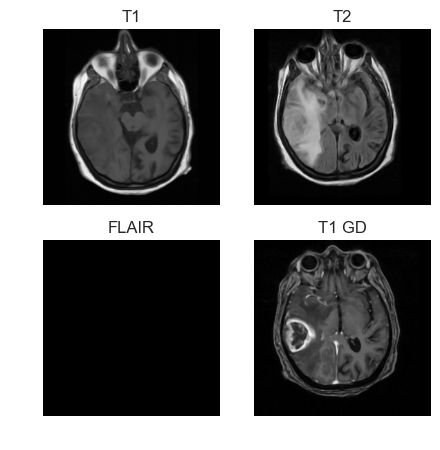

In [190]:
sitk_show_4seq(imgSmooth_4seq_slice)

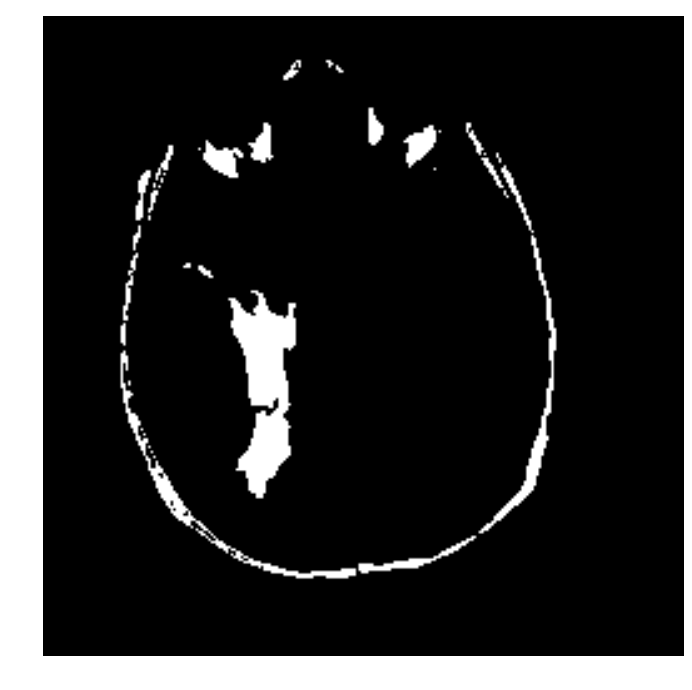

In [191]:
tumour_thres = SimpleITK.BinaryThreshold(imgSmooth_4seq[1], lowerThreshold=700, upperThreshold=900, 
                                                insideValue=labelTumour, outsideValue=0)
sitk_show(tumour_thres[:,:,9])

0


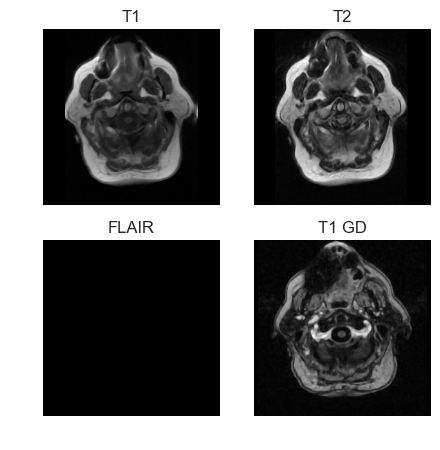

In [178]:
# Define initial slice to start looking for tumour
slice_max = 0

# Initialise filter to analyse tumour dimension in each slice
label_shape_analysis_thres = SimpleITK.LabelShapeStatisticsImageFilter()
label_shape_analysis_thres.SetBackgroundValue(0)
label_shape_analysis_thres.Execute(tumour_thres[:,:,slice_max])

# Check that tumour was detected in slice
if np.count_nonzero(SimpleITK.GetArrayFromImage(tumour_thres[:,:,slice_max])) > 0:
    # If so, compute number of pixels in tumour in this slice
    slice_pixels = label_shape_analysis_thres.GetNumberOfPixels(labelTumour)
else:
    slice_pixels = 0

# Loop through the rest of the slices and assign the slice with largest tumour area to slice_max
for s in range(slice_max+1, 20):
    if np.count_nonzero(SimpleITK.GetArrayFromImage(tumour_thres[:,:,s])) > 0:
        label_shape_analysis_thres.Execute(tumour_thres[:,:,s])
        pix = label_shape_analysis_thres.GetNumberOfPixels(labelTumour)
        if pix > slice_pixels:
            (slice_max, slice_pixels) = (s, pix)

# Define image slice in all four sequences
print slice_max
imgSmooth_4seq_slice10 = [imgSmooth_4seq[i][:,:,slice_max] for i in range(4)]

sitk_show_4seq(imgSmooth_4seq_slice10)

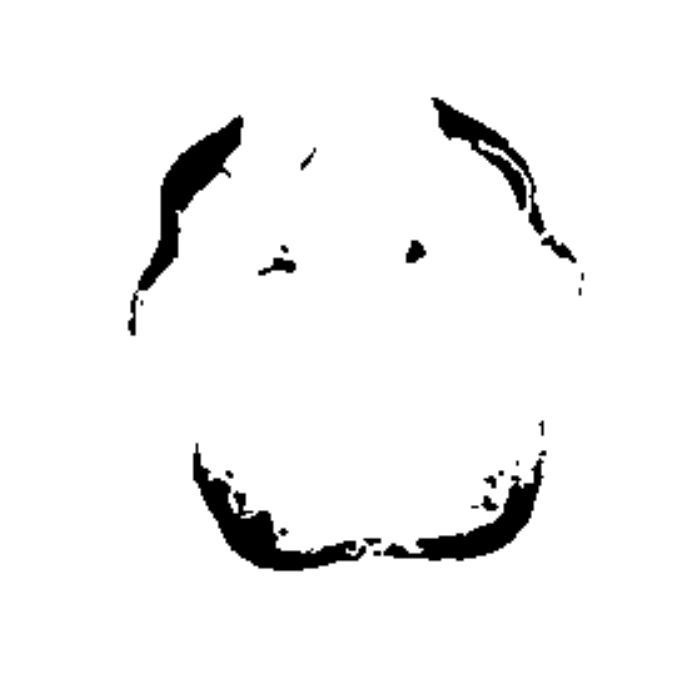

In [179]:
# Create seeds from thresholding segmentation
seeds_auto = np.argwhere(SimpleITK.GetArrayFromImage(tumour_thres)==labelTumour)

# Inverse dimensions as the function GetArryFromImage returns vertical image values in lines and horizontal image values in columns 
for seed in seeds_auto:
    seed[0], seed[1] = seed[1], seed[0]
    
# Refine tumour segmentation based on list of seeds previously assigned with Confidence Connected filter
imgTumourT2 = SimpleITK.ConfidenceConnected(image1=imgSmooth_4seq_slice10[1], 
                                               seedList=seeds_auto,
                                               numberOfIterations=3,
                                               multiplier=4,
                                               replaceValue=labelTumour)

sitk_show(imgTumourT2)

In [128]:
patient2_imgs = select_slice('900-00-5299')
patient2_tumour = segment_tumour('900-00-5299')

print 'Extracted lesion size:', Lesion_size_x(patient2_tumour), '-', Lesion_size_y(patient2_tumour)
print 'Manual lesion size:', tumours.loc[tumours['Sample']=='900_00_5299', 'Lesion_Size_x'].values[0], '-', tumours.loc[tumours['Sample']=='900_00_5299', 'Lesion_Size_y'].values[0], '\n'

print 'Extracted side of tumour epicentre:', Side_of_tumor_epicenter(patient2_tumour)
print 'Manual side of tumour epicentre:', tumours.loc[tumours['Sample']=='900_00_5299', 'Side_of_Tumor_Epicenter'].values[0], '\n'

print 'Extracted T1-FLAIR ratio:', T1_FLAIR_ratio(patient2_tumour)
print 'Manual T1-FLAIR ratio:', tumours.loc[tumours['Sample']=='900_00_5299', 'T1_FLAIR_Ratio'].values[0], '\n'

print 'Extracted enhancement quality:', enhancement_quality(get_tumour_intensity_arrays(patient2_tumour, patient2_imgs))
print 'Manual enhancement quality:', tumours.loc[tumours['Sample']=='900_00_5299', 'Enhancement_Quality'].values[0], '\n'

print 'Extracted proportion enhancing:', proportion_enhancing(get_tumour_intensity_arrays(patient2_tumour, patient2_imgs))
print 'Manual proportion enhancing:', tumours.loc[tumours['Sample']=='900_00_5299', 'Proportion_Enhancing'].values[0], '\n'

print 'Extracted proportion nCET:', proportion_nCET(get_tumour_intensity_arrays(patient2_tumour, patient2_imgs))
print 'Manual proportion nCET:', tumours.loc[tumours['Sample']=='900_00_5299', 'Proportion_nCET'].values[0], '\n'

print 'Proportion necrosis??'
print 'Manual proportion necrosis:', tumours.loc[tumours['Sample']=='900_00_5299', 'Proportion_Necrosis'].values[0], '\n'

print 'Extracted thickness of enhancing margin:', thickness_enhancing_margin(get_tumour_intensity_arrays(patient2_tumour, patient2_imgs))
print 'Manual thickness of enhancing margin:', tumours.loc[tumours['Sample']=='900_00_5299', 'Thickness_Enhancing_Margin'].values[0], '\n'

 Extracted lesion size: 18 - 18
Manual lesion size: 11 - 8 

Extracted side of tumour epicentre: 1
Manual side of tumour epicentre: 1 

Extracted T1-FLAIR ratio: 3
Manual T1-FLAIR ratio: 2 

Extracted enhancement quality: 3
Manual enhancement quality: 3 

Extracted proportion enhancing: 8
Manual proportion enhancing: 4 

Extracted proportion nCET: 3
Manual proportion nCET: 3 

Proportion necrosis??
Manual proportion necrosis: 4 

Extracted thickness of enhancing margin: 4
Manual thickness of enhancing margin: 4 



---

<a id='Part9'></a>

## 9. Executive Summary

The project aim was to build a model to predict probabilities for a tumour to be of a certain type (Astrocytoma, Glioblastoma (GBM) or Oligodendroglioma) in order to assist radiologists in their diagnosis.  
  
In order to select the most relevant model, we tested the cross-validated accuracy and confusion matrices of five different models (Logistic Regression, k-nearest neighbours (KNN), Random Forest, Linear Discriminant Analysis (LDA) and Naive Bayes. We then optimised the first three models parameters using GridSearchCV. Finally we tried reducing the number of features using the SelectKBest method, recursive feature elimination (RFE) and Random Forest's features ranking in order to improve model performance and reduce the number of features to be automtically extracted from other images. We performed the analysis on the initial VASARI dataset of 32 patients for whom 30 tumour features had been extracted manually by radiologists.  

Based on this study, a random forest model with 25 estimators based on the selected 5 best tumour features (Enhancement quality, Proportion enhancing, Proportion necrosis, Proportion nCET, Thickness of enhancing margin) seemed to be performing best. The five features that were used (selected by SelectKBest) seemed to be consistent with the features selected by the other techniques - the top 3 features (Enhancement quality, Proportion nCET, Thickness of enhancing margin) were the same in all techniques and the others were in all techniques' top 10. The features also seem to be consistent with the main characteristics that differentiate tumours - in particular enhancing margin, necrosis and enhancement characterise GBMs.   
** CHECK !! More?? **   
  
The selected model gives a cross-validated accuracy of 91% +/- 1.2%.   
  
However this model has currently only been tested (cross-validated) on 32 samples so our model might be overfitting the data. We have also introduced some selection bias in our model accuracy as we optimised our models on the same set of data that was used to estimate the final model score. We will need to extract features from the remaining 98 images in order to provide an unbiased estimation of our model's performance.  
   
Regarding image features extraction, some work remains to be done. So far we have been able to upload images for one patient, filter them to remove MRI noise and reshape them, isolate the tumour and extract half of the features. Some features such as thickness of enchancing margin and proportion necrosis still need to be exctracted. Also, the process needs to be automated so we can extract features from other images - at the moment some steps of the process require manual selection (such as selecting tumour seeds) and general pipelines/functions need to be created to encompass the whole process.  

----------

Explain your research with a summary, reviewing the strengths and weaknesses of any variables in the process.  

Many modeling approaches are all about fine-tuning the algorithm parameters and trying to find a specific value. Show how you optimized for this value, and the costs/benefits of doing so. Explain why you have chosen one or many feature(s) over others. Identify what other data and/or features could help your model.  
   
It would be good to discuss if the accuracy you reach is sufficient to have impact on the diagnosis and if the features you recognise as being the most important ones are the ones you would have expected.
    
Interpretation of findings & relation to goals/success metrics  
Description of any source code used to conduct analysis  
Stakeholder recommendations & next steps for model/peers  
Describe how you could validate your model's performance over time  

# TO IMPROVE!

 - giving some background knowledge about the tumour types, their location and the general difficulties in detecting them. 
 - Describe further if you have to make any assumptions for your modelling (e.g. data distribution, existence of outliers). 